# **Faster RCNN**

In [ ]:
import zipfile
import os

# Unzip dataset
dataset_path = '/content/RiceLeafDiseasedetectionobj.v2i.coco.zip'
output_dir = '/content/'
with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall(output_dir)

# Verify structure
os.listdir(output_dir)

['.config',
 'train',
 'faster_rcnn_full_model.pt',
 'valid',
 'RiceLeafDiseasedetectionobj.v2i.coco.zip',
 'README.roboflow.txt',
 'README.dataset.txt',
 'test',
 'sample_data']

In [ ]:
import os
import json
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import collections

# Define the path to the base directory where train, valid, test folders are stored
base_dir = '/content/'

# Folders to check
folders = ['train', 'valid', 'test']

# Initialize categories to keep track of categories across all datasets
all_categories = {}
coco_data = {}

# Function to load and check annotation files
def check_annotations(folder_name):
    annotation_file = os.path.join(base_dir, folder_name, '_annotations.coco.json')

    if os.path.exists(annotation_file):
        print(f"\nChecking annotations for the {folder_name} folder:")
        with open(annotation_file, 'r') as f:
            coco_data[folder_name] = json.load(f)

        # Print an overview of the annotations
        print("Categories: ", coco_data[folder_name].get('categories', 'No categories found'))
        print("Number of Images: ", len(coco_data[folder_name].get('images', [])))
        print("Number of Annotations: ", len(coco_data[folder_name].get('annotations', [])))

        # Add categories to the global dictionary
        for category in coco_data[folder_name]['categories']:
            all_categories[category['id']] = category['name']

        # Check if 'image_id', 'category_id', and 'bbox' fields are present in annotations
        if coco_data[folder_name].get('annotations'):
            for annotation in coco_data[folder_name]['annotations'][:5]:  # Print first 5 annotations as a sample
                print("Annotation example: ", annotation)
                assert 'image_id' in annotation, "Missing 'image_id' in annotation"
                assert 'category_id' in annotation, "Missing 'category_id' in annotation"
                assert 'bbox' in annotation, "Missing 'bbox' in annotation"
        else:
            print(f"No annotations found in {folder_name}!")
    else:
        print(f"Annotation file not found in {folder_name} folder")

# Check annotations for all folders: train, valid, test
for folder in folders:
    check_annotations(folder)


Checking annotations for the train folder:
Categories:  [{'id': 0, 'name': 'rice-leaf-diseases', 'supercategory': 'none'}, {'id': 1, 'name': 'Brown spot', 'supercategory': 'rice-leaf-diseases'}, {'id': 2, 'name': 'Leaf Blight', 'supercategory': 'rice-leaf-diseases'}, {'id': 3, 'name': 'Leaf Scald', 'supercategory': 'rice-leaf-diseases'}, {'id': 4, 'name': 'Leaf blast', 'supercategory': 'rice-leaf-diseases'}, {'id': 5, 'name': 'Narrow brown spot', 'supercategory': 'rice-leaf-diseases'}, {'id': 6, 'name': 'healthy', 'supercategory': 'rice-leaf-diseases'}]
Number of Images:  2997
Number of Annotations:  7290
Annotation example:  {'id': 0, 'image_id': 0, 'category_id': 5, 'bbox': [271, 0, 70.8, 380.8], 'area': 26960.64, 'segmentation': [[271.2, 0, 272.4, 10.8, 271.2, 29.6, 276.4, 104.4, 272.8, 135.6, 272.8, 170, 275.6, 187.2, 279.6, 194, 281.6, 201.6, 282, 218.8, 286, 230, 290, 250, 292.4, 274.4, 290.8, 303.6, 293.6, 336.4, 296.8, 348, 305.2, 361.2, 309.2, 364.4, 315.2, 364.4, 323.6, 367.

In [ ]:
# Extract category names from the aggregated categories
print("\nAll Disease categories across datasets: ", all_categories)


All Disease categories across datasets:  {0: 'rice-leaf-diseases', 1: 'Brown spot', 2: 'Leaf Blight', 3: 'Leaf Scald', 4: 'Leaf blast', 5: 'Narrow brown spot', 6: 'healthy'}


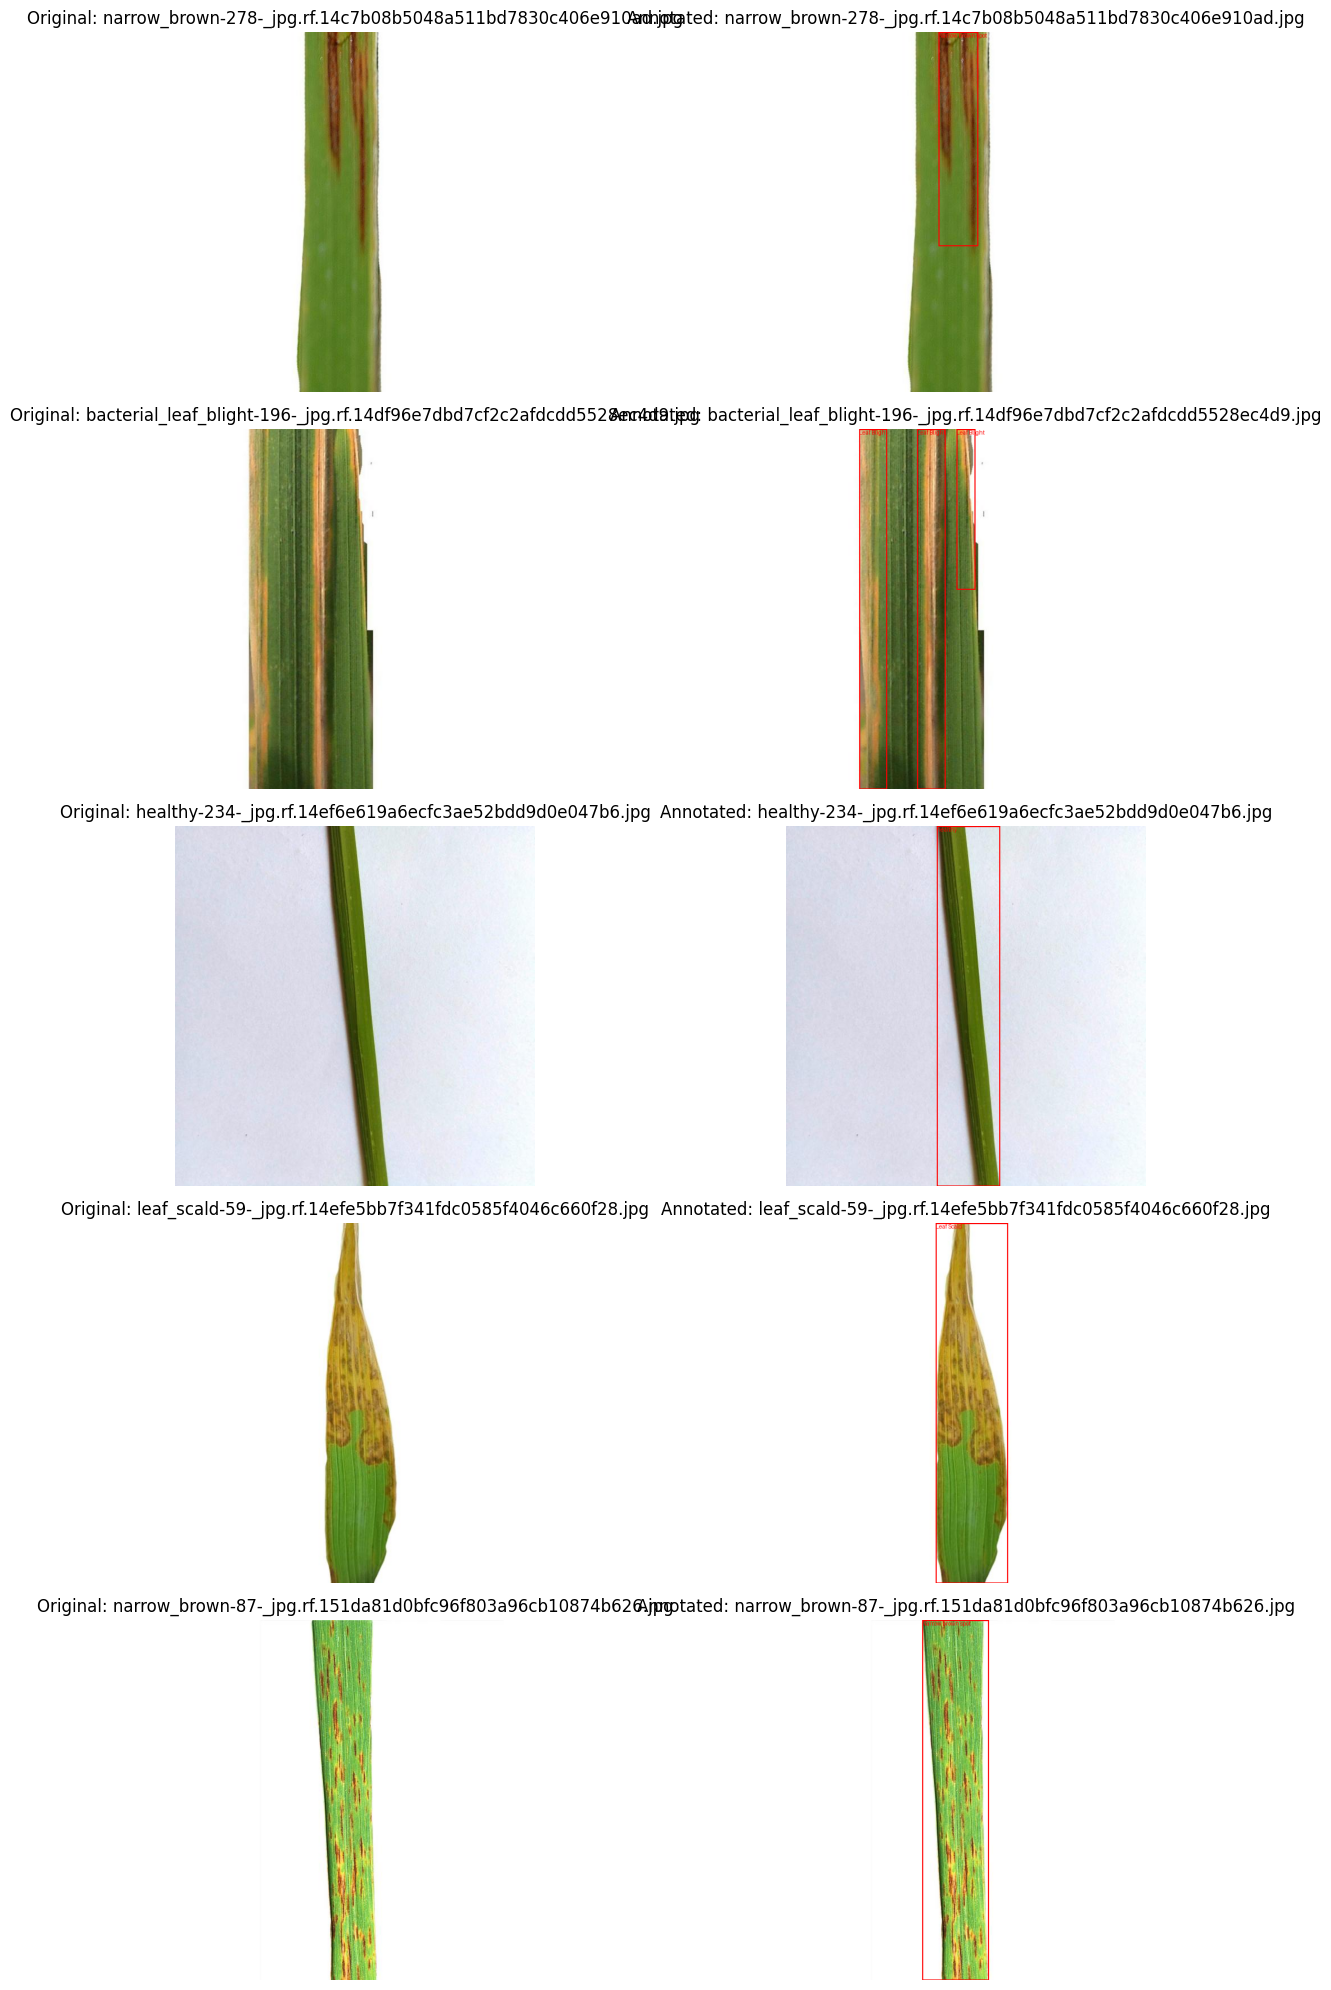

In [ ]:
# Function to display images and annotations for a specific image
def display_image_with_annotations(folder_name, image_id):
    # Find the image info
    image_info = next(img for img in coco_data[folder_name]['images'] if img['id'] == image_id)
    file_name = image_info['file_name']
    image_path = os.path.join(base_dir, folder_name, file_name)

    # Open the image
    img = Image.open(image_path)

    # Create a drawing context to draw bounding boxes
    draw = ImageDraw.Draw(img)

    # Get all annotations for the image
    image_annotations = [ann for ann in coco_data[folder_name]['annotations'] if ann['image_id'] == image_id]

    # Draw the bounding boxes and label them with class names
    for ann in image_annotations:
        category_id = ann['category_id']
        bbox = ann['bbox']
        disease_name = all_categories[category_id]

        # Draw bounding box (in COCO format, bbox = [x, y, width, height])
        x, y, width, height = bbox
        draw.rectangle([x, y, x + width, y + height], outline="red", width=2)

        # Draw label
        draw.text((x, y), disease_name, fill="red")

    return img

# Display 5 sample images with annotations from the train dataset
fig, axs = plt.subplots(5, 2, figsize=(15, 20))

for i, ax in enumerate(axs):
    # Display original image on the left
    image_info = coco_data['train']['images'][i]
    original_image_path = os.path.join(base_dir, 'train', image_info['file_name'])
    original_image = Image.open(original_image_path)
    ax[0].imshow(original_image)
    ax[0].set_title(f"Original: {image_info['file_name']}")
    ax[0].axis('off')

    # Display image with annotations on the right
    annotated_image = display_image_with_annotations('train', image_info['id'])
    ax[1].imshow(annotated_image)
    ax[1].set_title(f"Annotated: {image_info['file_name']}")
    ax[1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import torchvision.transforms as T

transform = T.Compose([
    T.Resize((640, 640)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets.coco import CocoDetection

# Load datasets using COCO format
train_dataset = CocoDetection(root=os.path.join(base_dir, 'train'),
                              annFile=os.path.join(base_dir, 'train', '_annotations.coco.json'),
                              transform=transform)

valid_dataset = CocoDetection(root=os.path.join(base_dir, 'valid'),
                              annFile=os.path.join(base_dir, 'valid', '_annotations.coco.json'),
                              transform=transform)

# Create DataLoader for train and validation sets
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [ ]:
!pip install torchvision

In [ ]:
# Import the necessary libraries
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import torch
import torch.optim as optim
from tqdm import tqdm
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN

# Modify the number of classes (7 classes including background)
num_classes = 7  # 6 diseases + background

# Load pretrained Faster R-CNN model
model = fasterrcnn_resnet50_fpn(weights='FasterRCNN_ResNet50_FPN_Weights.DEFAULT')

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 90.8MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
import torch
import torch.optim as optim
from tqdm import tqdm


# Set the number of epochs
num_epochs = 5

# Set the optimizer (using SGD as it is commonly used for object detection models)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)

# Learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


def prepare_targets(targets):
    formatted_targets = []
    for t in targets:
        if len(t) == 0:
            print("No annotations for this image, skipping...")
            continue

        # Extract bounding boxes and check for validity
        boxes = torch.tensor([ann['bbox'] for ann in t if 'bbox' in ann], dtype=torch.float32)
        if boxes.size(0) == 0:
            print("No valid bounding boxes found for this image, skipping...")
            continue

        # Convert [x, y, width, height] -> [x_min, y_min, x_max, y_max]
        boxes[:, 2:] += boxes[:, :2]

        # Filter out invalid boxes (e.g., negative or zero-size)
        valid_boxes = []
        valid_labels = []
        for i, box in enumerate(boxes):
            x_min, y_min, x_max, y_max = box
            if (x_max > x_min) and (y_max > y_min):
                valid_boxes.append(box)
                valid_labels.append(t[i]['category_id'])
            else:
                print(f"Invalid bounding box removed: {box.tolist()}")

        if valid_boxes:
            formatted_target = {
                'boxes': torch.stack(valid_boxes),
                'labels': torch.tensor(valid_labels, dtype=torch.int64)
            }
            formatted_targets.append(formatted_target)
        else:
            print("No valid bounding boxes for this image, skipping...")

    return formatted_targets

# Debugging during DataLoader creation
def print_sample_annotations(dataset):
    for idx in range(5):  # Print the first 5 images for debugging
        img, annotations = dataset[idx]
        print(f"Image {idx} - Number of annotations: {len(annotations)}")
        for ann in annotations:
            print(f"  Annotation: {ann}")

print("Sample annotations from training dataset:")
print_sample_annotations(train_dataset)


Sample annotations from training dataset:
Image 0 - Number of annotations: 1
  Annotation: {'id': 0, 'image_id': 0, 'category_id': 5, 'bbox': [271, 0, 70.8, 380.8], 'area': 26960.64, 'segmentation': [[271.2, 0, 272.4, 10.8, 271.2, 29.6, 276.4, 104.4, 272.8, 135.6, 272.8, 170, 275.6, 187.2, 279.6, 194, 281.6, 201.6, 282, 218.8, 286, 230, 290, 250, 292.4, 274.4, 290.8, 303.6, 293.6, 336.4, 296.8, 348, 305.2, 361.2, 309.2, 364.4, 315.2, 364.4, 323.6, 367.2, 332.4, 380.8, 335.6, 373.2, 337.2, 361.2, 340, 272.8, 332.4, 203.2, 332, 136, 342, 70.8, 341.6, 15.6, 339.2, 9.6, 336.4, 8.4, 338.8, 6.4, 340.8, 0, 335.6, 0, 335.6, 4, 334, 6, 326.4, 2.4, 316.8, 2.8, 309.2, 8.4, 297.6, 12.8, 291.2, 8.4, 293.2, 0, 271.2, 0]], 'iscrowd': 0}
Image 1 - Number of annotations: 3
  Annotation: {'id': 1, 'image_id': 1, 'category_id': 2, 'bbox': [233, 0, 50, 640], 'area': 32000, 'segmentation': [], 'iscrowd': 0}
  Annotation: {'id': 2, 'image_id': 1, 'category_id': 2, 'bbox': [130, 0, 49, 640], 'area': 31360, '

In [ ]:
# Function to train for one epoch
def train_one_epoch(model, optimizer, train_loader, device, epoch):
    model.train()  # Set model to training mode
    running_loss = 0.0

    # Use tqdm to show progress bar
    progress_bar = tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}")

    for images, targets in progress_bar:
        # Move images to the appropriate device
        images = [image.to(device) for image in images]

        # Prepare targets (fixing the structure and validating bounding boxes)
        targets = prepare_targets(targets)

        # Check if targets is empty after prepare_targets
        if not targets:
            print("Skipping this batch due to no valid targets.")
            continue

        # Move targets to the appropriate device
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Check if images and targets have the same length
        if len(images) != len(targets):
            print("Skipping this batch due to mismatch in number of images and targets.")
            continue

        # Forward pass: calculate loss
        loss_dict = model(images, targets)

        # Ensure the losses are not empty or invalid
        losses = sum(loss for loss in loss_dict.values())
        running_loss += losses.item()

        # Backward pass and optimize
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        # Update progress bar with current loss
        progress_bar.set_postfix(loss=running_loss / len(progress_bar))

    return running_loss / len(train_loader)

# Function to evaluate on the validation set
def evaluate(model, valid_loader, device):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0

    with torch.no_grad():  # Disable gradient calculations for evaluation
        for images, targets in tqdm(valid_loader, desc="Validating"):
            images = [image.to(device) for image in images]

            # Prepare targets (fixing the structure and validating bounding boxes)
            targets = prepare_targets(targets)

            if not targets:
                print("Skipping this batch due to no valid targets.")
                continue

            # Move targets to the appropriate device
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Check if images and targets have the same length
            if len(images) != len(targets):
                print("Skipping this batch due to mismatch in number of images and targets.")
                continue

            # Forward pass
            loss_dict = model(images, targets)

            # Ensure the losses are valid
            losses = sum(loss for loss in loss_dict.values())
            running_loss += losses.item()

    return running_loss / len(valid_loader)

In [ ]:
import torch

# Function to prepare targets
def prepare_targets(targets):
    formatted_targets = []

    for t in targets:
        if len(t) == 0:  # Skip images without annotations
            continue

        valid_boxes = []
        valid_labels = []

        # Process all annotations in an image
        for ann in t:
            if 'bbox' in ann:
                x, y, width, height = ann['bbox']
                x_min, y_min = x, y
                x_max, y_max = x + width, y + height  # Convert to (x_min, y_min, x_max, y_max)

                # Check if the bounding box is valid (i.e., non-zero area)
                if x_max > x_min and y_max > y_min:
                    valid_boxes.append([x_min, y_min, x_max, y_max])
                    valid_labels.append(ann['category_id'])

        # Only add if there are valid annotations
        if valid_boxes:
            formatted_target = {
                'boxes': torch.tensor(valid_boxes, dtype=torch.float32),
                'labels': torch.tensor(valid_labels, dtype=torch.int64)
            }
            formatted_targets.append(formatted_target)

    return formatted_targets if formatted_targets else None  # Return None if no valid targets found

# Assuming train_loader is already defined
def train_one_epoch(model, optimizer, train_loader, device, epoch):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Training Epoch {epoch+1}")

    for images, targets in progress_bar:
        images = [image.to(device) for image in images]
        targets = prepare_targets(targets)

        if targets is None or len(images) != len(targets):
            continue  # Skip if no valid targets or mismatch in images and targets

        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        running_loss += losses.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        # Update the progress bar with current loss
        progress_bar.set_postfix(loss=running_loss / len(progress_bar))

    return running_loss / len(train_loader)

# Train the model with a loader that provides images and corresponding annotations
def train_model(model, train_loader, num_epochs, optimizer, scheduler, device):
    for epoch in range(num_epochs):
        train_loss = train_one_epoch(model, optimizer, train_loader, device, epoch)
        print(f"Epoch {epoch+1}, Loss: {train_loss}")

        scheduler.step()

# Load pretrained model, optimizer, scheduler, etc. (as described before)
# Assuming you have a DataLoader 'train_loader' that returns images and corresponding annotations
train_model(model, train_loader, num_epochs=3, optimizer=optimizer, scheduler=lr_scheduler, device=device)


Training Epoch 1: 100%|██████████| 750/750 [09:01<00:00,  1.39it/s, loss=0.394]


Epoch 1, Loss: 0.39434130455056826


Training Epoch 2: 100%|██████████| 750/750 [08:56<00:00,  1.40it/s, loss=0.319]


Epoch 2, Loss: 0.31920852384964626


Training Epoch 3: 100%|██████████| 750/750 [08:55<00:00,  1.40it/s, loss=0.294]

Epoch 3, Loss: 0.2942282891869545


In [ ]:
# Load test dataset using COCO format
test_dataset = CocoDetection(root=os.path.join(base_dir, 'test'),
                             annFile=os.path.join(base_dir, 'test', '_annotations.coco.json'),
                             transform=transform)

# Create DataLoader for the test set
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [ ]:
from torchvision.ops import box_iou

def evaluate_on_test(model, test_loader, device):
    model.eval()  # Set model to evaluation mode
    all_boxes = []
    all_labels = []
    all_scores = []

    with torch.no_grad():  # Disable gradient calculations for evaluation
        for images, targets in tqdm(test_loader, desc="Evaluating"):
            images = [image.to(device) for image in images]

            # Prepare targets (fixing the structure and validating bounding boxes)
            targets = prepare_targets(targets)

            # Get predictions
            predictions = model(images)

            # Collect boxes, labels, and scores for evaluation
            for i, prediction in enumerate(predictions):
                if len(prediction['boxes']) > 0:
                    all_boxes.append(prediction['boxes'].cpu())
                    all_labels.append(prediction['labels'].cpu())
                    all_scores.append(prediction['scores'].cpu())

    return all_boxes, all_labels, all_scores


In [ ]:
import numpy as np
import torch
from sklearn.metrics import average_precision_score

def compute_map(all_boxes, all_labels, all_scores, num_classes):
    y_true = np.zeros((0, num_classes))  # Initialize empty one-hot encoded array
    y_scores = np.zeros((0, num_classes))  # Initialize empty 2D scores array

    for cls in range(num_classes):
        cls_boxes = []
        cls_scores = []
        cls_labels = []

        for boxes, labels, scores in zip(all_boxes, all_labels, all_scores):
            # Ensure labels is a NumPy array
            labels = labels.numpy() if isinstance(labels, torch.Tensor) else labels

            # Create a mask for the current class
            cls_mask = (labels == cls)
            if np.any(cls_mask):  # Ensure there are samples for this class
                cls_boxes.append(boxes[cls_mask])
                cls_scores.append(scores[cls_mask])
                cls_labels.append(labels[cls_mask])

        if cls_boxes:
            cls_boxes = torch.cat(cls_boxes)
            cls_scores = torch.cat(cls_scores)

            # Convert cls_labels to tensors before concatenation
            cls_labels = torch.cat([torch.from_numpy(l) for l in cls_labels])

            # Prepare true labels in one-hot encoding
            cls_true_labels = np.zeros((len(cls_labels), num_classes))
            cls_true_labels[:, cls] = 1  # Set the corresponding class index to 1

            # Append true labels and scores
            y_true = np.vstack((y_true, cls_true_labels))

            # Convert cls_scores to 2D array where each class has its own column
            cls_score_2d = np.zeros((len(cls_scores), num_classes))
            cls_score_2d[:, cls] = cls_scores.numpy()  # Put scores in the corresponding class column
            y_scores = np.vstack((y_scores, cls_score_2d))

    # Calculate average precision
    average_precision = average_precision_score(y_true, y_scores, average='macro')
    return average_precision


In [ ]:
# Evaluate on the test dataset
all_boxes, all_labels, all_scores = evaluate_on_test(model, test_loader, device)

# Compute mAP
map_score = compute_map(all_boxes, all_labels, all_scores, num_classes)
print(f"Mean Average Precision (mAP) on the test dataset: {map_score:.4f}")


Evaluating: 100%|██████████| 62/62 [00:22<00:00,  2.73it/s]

Mean Average Precision (mAP) on the test dataset: 0.8571



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


In [ ]:
import os
import torch
import numpy as np
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader
import torchvision.transforms as T

# Function to compute IoU between two bounding boxes
def calculate_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

# Function to compute Dice coefficient between two bounding boxes
def calculate_dice(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    dice = (2 * interArea) / float(boxAArea + boxBArea)
    return dice

# Unified function to preprocess the image (same as training preprocessing)
def preprocess_image(image):
    # Check if the input is a tensor; if so, return it as is
    if isinstance(image, torch.Tensor):
        return image  # No need to preprocess

    # Otherwise, apply transformations
    transform = T.Compose([
        T.Resize((640, 640)),  # Resize to 640x640 (same as training)
        T.ToTensor(),  # Convert image to tensor
        T.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize using ImageNet mean
                    std=[0.229, 0.224, 0.225])  # Normalize using ImageNet std
    ])
    return transform(image)

# Function to compute IoU and Dice across the entire dataset with preprocessing
def evaluate_model_on_dataset(model, test_loader, device):
    iou_scores = []
    dice_scores = []

    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        for images, annotations in test_loader:
            # Apply preprocessing to the batch of images
            images = [preprocess_image(image).to(device) for image in images]

            # Make predictions
            predictions = model(images)

            # Loop over each image in the batch
            for i, prediction in enumerate(predictions):
                predicted_boxes = prediction['boxes'].cpu().numpy()
                gt_boxes = np.array([ann['bbox'] for ann in annotations[i]])

                # Adjust ground truth boxes to (x_min, y_min, x_max, y_max)
                gt_boxes = np.array([[x, y, x + w, y + h] for x, y, w, h in gt_boxes])

                # Compute IoU and Dice for each predicted box with ground truth boxes
                for pred_box in predicted_boxes:
                    iou_per_box = [calculate_iou(pred_box, gt_box) for gt_box in gt_boxes]
                    dice_per_box = [calculate_dice(pred_box, gt_box) for gt_box in gt_boxes]

                    if iou_per_box:
                        iou_scores.append(max(iou_per_box))  # Take the highest IoU
                    if dice_per_box:
                        dice_scores.append(max(dice_per_box))  # Take the highest Dice coefficient

    avg_iou = np.max(iou_scores) if iou_scores else 0.0
    avg_dice = np.max(dice_scores) if dice_scores else 0.0

    return avg_iou, avg_dice

# Load test dataset using COCO format with no transformation initially
test_dataset = CocoDetection(root=os.path.join(base_dir, 'test'),
                             annFile=os.path.join(base_dir, 'test', '_annotations.coco.json'),
                             transform= transform)  # Preprocessing applied later

# Create DataLoader for test dataset
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# Load the Faster R-CNN model
model_path = '/content/faster_rcnn_full_model.pt'
model = torch.load(model_path, map_location=torch.device('cpu'))

# Set device (CPU or CUDA)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Evaluate the model on the test dataset with preprocessing
avg_iou, avg_dice = evaluate_model_on_dataset(model, test_loader, device)

print(f"Average IoU: {avg_iou}")
print(f"Average Dice Coefficient: {avg_dice}")


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Average IoU: 0.8425645209436431
Average Dice Coefficient: 0.8217560685022745


In [ ]:
import os
import torch
import numpy as np
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader
import torchvision.transforms as T

# Unified function to preprocess the image (same as training preprocessing)
def preprocess_image(image):
    if isinstance(image, torch.Tensor):
        return image  # If it's already a tensor, return it
    transform = T.Compose([
        T.Resize((640, 640)),  # Resize to 640x640 (same as training)
        T.ToTensor(),  # Convert image to tensor
        T.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize using ImageNet mean
                    std=[0.229, 0.224, 0.225])  # Normalize using ImageNet std
    ])
    return transform(image)

# Function to compute Precision and Recall based on predicted class labels
def evaluate_precision_recall_on_dataset(model, test_loader, device, conf_threshold=0.7):
    # Initialize counts
    tp = 0  # True Positives
    fp = 0  # False Positives
    fn = 0  # False Negatives

    model.eval()  # Set model to evaluation mode

    with torch.no_grad():
        for images, annotations in test_loader:
            # Preprocess images and send to device
            images = [preprocess_image(image).to(device) for image in images]

            # Get predictions from the model
            predictions = model(images)

            # Loop over each image in the batch
            for i, prediction in enumerate(predictions):
                predicted_labels = prediction['labels'].cpu().numpy()  # Predicted class labels
                predicted_scores = prediction['scores'].cpu().numpy()  # Prediction confidence scores

                # Apply confidence threshold
                predicted_labels = predicted_labels[predicted_scores >= conf_threshold]

                gt_labels = np.array([ann['category_id'] for ann in annotations[i]])  # Ground truth labels

                # Compute TP, FP, FN based on class labels
                for pred_label in predicted_labels:
                    if pred_label in gt_labels:
                        tp += 1  # Correct class prediction
                    else:
                        fp += 1  # Incorrect class prediction

                # FN: Ground truth labels not detected by the model
                fn += len(gt_labels) - sum([1 for gt_label in gt_labels if gt_label in predicted_labels])

    # Calculate precision and recall
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0

    return precision, recall

# Load test dataset using COCO format
base_dir = '/content/Rice-leaf-disease-1'
test_dataset = CocoDetection(root=os.path.join(base_dir, 'test'),
                             annFile=os.path.join(base_dir, 'test', '_annotations.coco.json'))

# Create DataLoader for test dataset
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
# Set device (CPU or CUDA)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Adjust confidence threshold as needed
confidence_threshold = 0.5  # You can adjust this value

# Evaluate the model on the test dataset for Precision and Recall
precision, recall = evaluate_precision_recall_on_dataset(model, test_loader, device, conf_threshold=confidence_threshold)

# Convert to percentages
precision_percentage = precision * 100
recall_percentage = recall * 100

print(f"Precision (P%): {precision_percentage:.2f}%")
print(f"Recall (R%): {recall_percentage:.2f}%")

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Precision (P%): 86.00%
Recall (R%): 78.00%


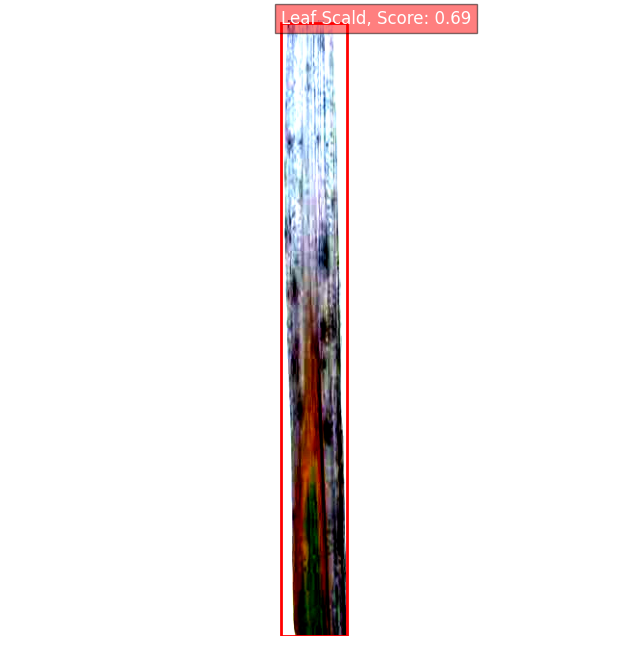

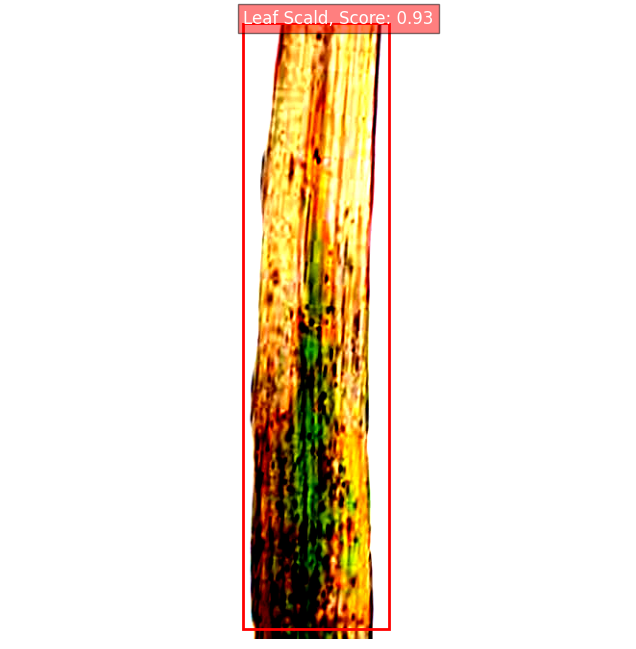

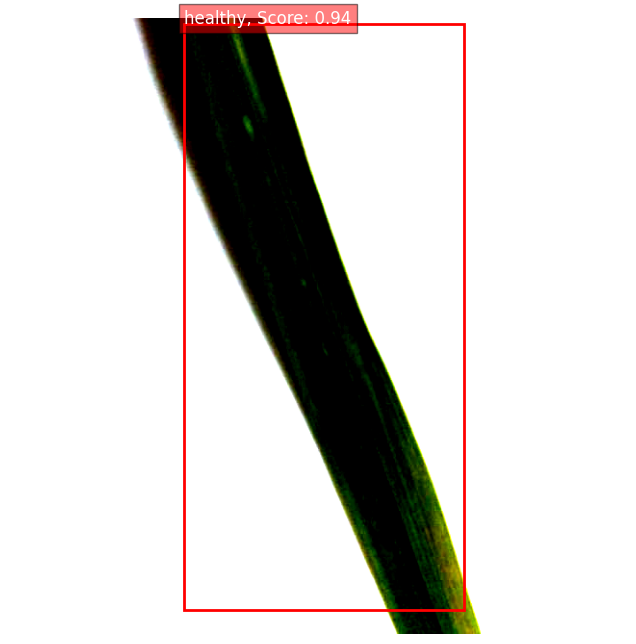

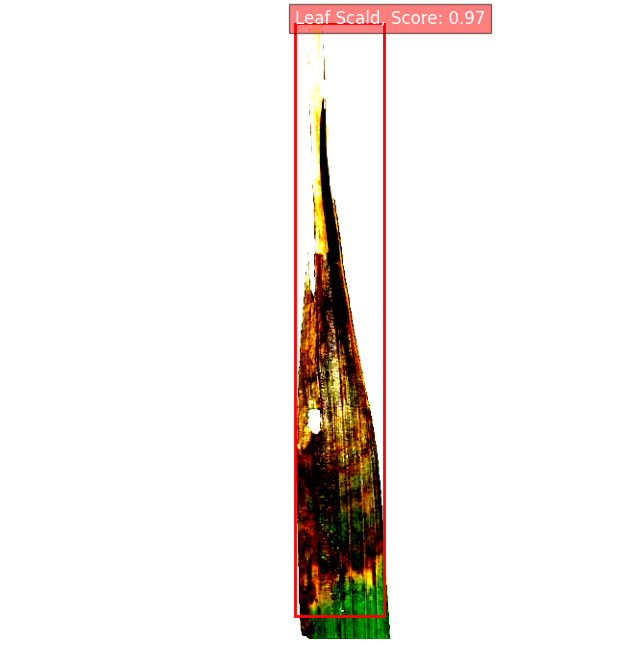

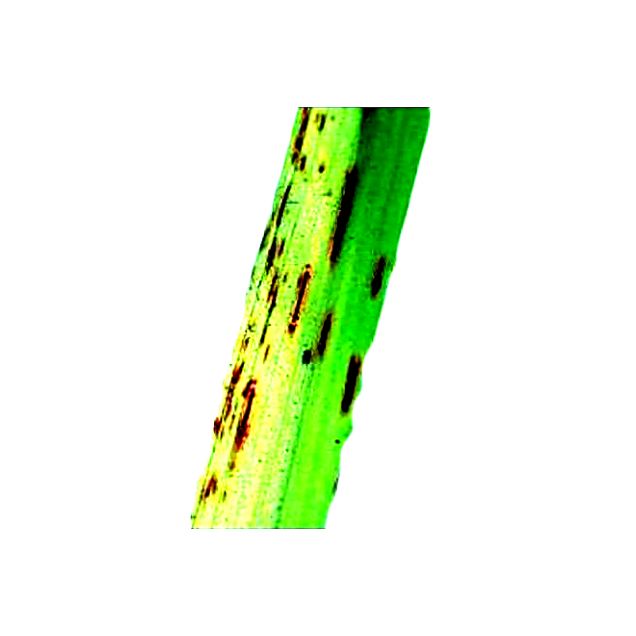

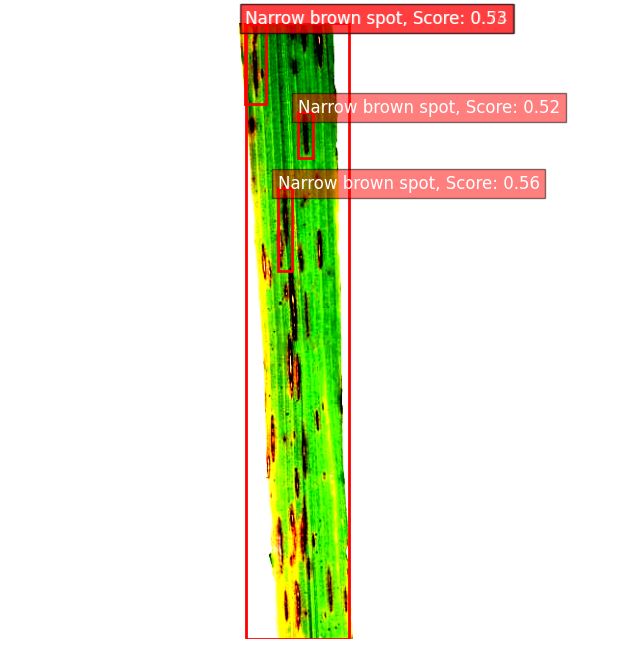

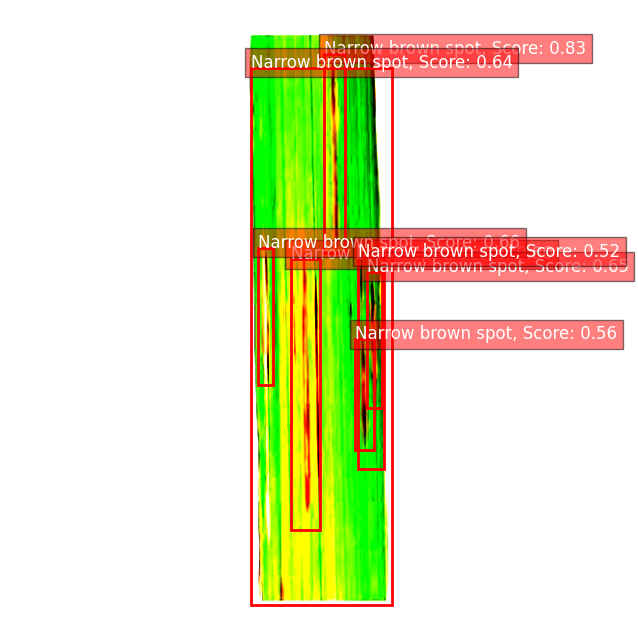

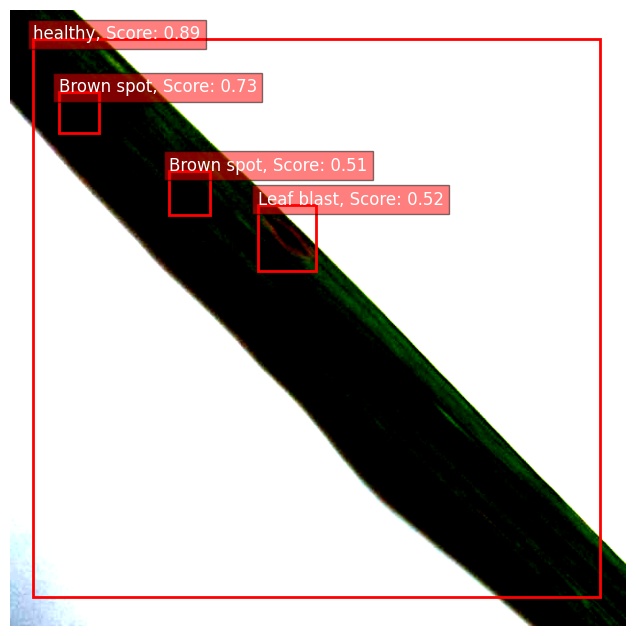

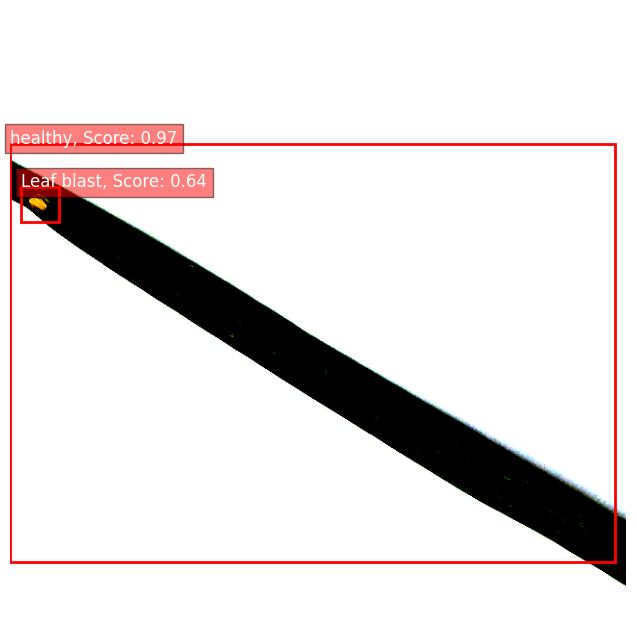

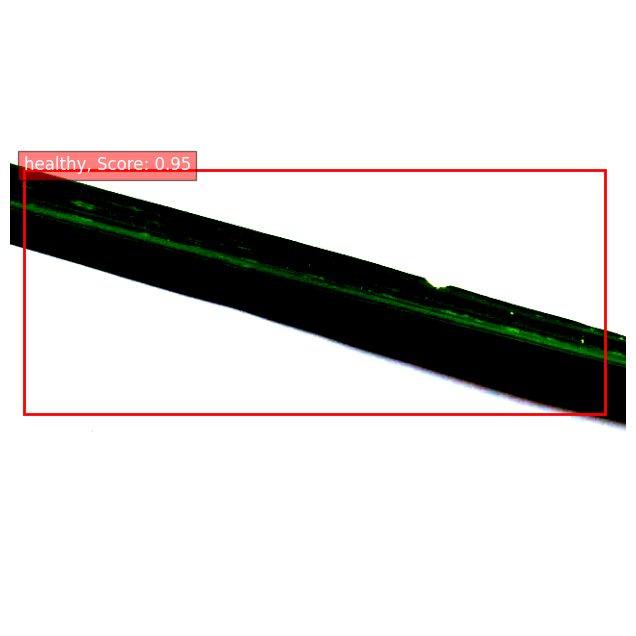

In [ ]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Assuming you have a mapping of class indices to class names
class_names = {0: 'rice-leaf-diseases', 1: 'Brown spot', 2: 'Leaf Blight', 3: 'Leaf Scald', 4: 'Leaf blast', 5: 'Narrow brown spot', 6: 'healthy'}  # Update with your actual class names

# Function to visualize predictions
def visualize_predictions(images, predictions, class_names, num_samples=10):
    for i in range(num_samples):
        # Get the original image
        image = images[i].permute(1, 2, 0).cpu().numpy()  # Convert to HWC format

        # Draw predicted boxes
        boxes = predictions[i]['boxes'].cpu().detach().numpy()  # Use detach to avoid tracking gradients
        labels = predictions[i]['labels'].cpu().detach().numpy()
        scores = predictions[i]['scores'].cpu().detach().numpy()

        # Display the image
        plt.figure(figsize=(12, 8))
        plt.imshow(image)

        for box, label, score in zip(boxes, labels, scores):
            if score > 0.5:  # Show boxes with a score above a certain threshold
                x_min, y_min, x_max, y_max = box  # Adjust based on your box format
                rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                     fill=False, color='red', linewidth=2)
                plt.gca().add_patch(rect)
                # Replace label with class name
                class_name = class_names[int(label)]
                plt.text(x_min, y_min, f'{class_name}, Score: {score:.2f}',
                         color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

        plt.axis('off')
        plt.show()

# Function to evaluate and get predictions from the model
def get_predictions(model, data_loader, device):
    model.eval()
    all_images = []
    all_predictions = []

    with torch.no_grad():
        for images, _ in data_loader:  # Get only images, ignore targets
            images = [img.to(device) for img in images]
            predictions = model(images)  # Forward pass
            all_images.extend(images)
            all_predictions.extend(predictions)

    return all_images, all_predictions


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Get predictions
all_images, all_predictions = get_predictions(model, test_loader, device)

# Visualize the results
visualize_predictions(all_images, all_predictions, class_names, num_samples=10)


<ipython-input-9-c86fae368796>:72: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)  # Directly load the model


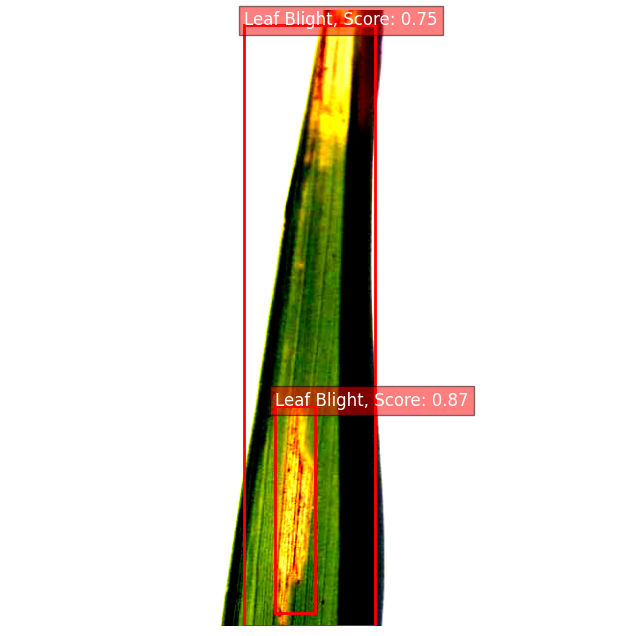

In [ ]:
import matplotlib.pyplot as plt

import torch
from PIL import Image
import torchvision.transforms as T

# Function to preprocess the image
def preprocess_image(image_path, device):
    # Define the transformation for the input image (Resize, Normalize, etc.)
    transform = T.Compose([
        T.Resize((640, 640)),  # Resize to 640x640
        T.ToTensor(),  # Convert image to tensor
        T.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize using ImageNet mean
                    std=[0.229, 0.224, 0.225])  # Normalize using ImageNet std
    ])

    # Load the image using PIL
    image = Image.open(image_path).convert("RGB")

    # Apply transformations
    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device
    return image_tensor, image


# Function to visualize the prediction on a user-provided image
def visualize_user_image(image, predictions, class_names):
    # Convert tensor image to numpy array for visualization
    image_np = image.permute(1, 2, 0).cpu().numpy()  # Convert to HWC format

    # Draw predicted boxes
    boxes = predictions[0]['boxes'].cpu().detach().numpy()  # Use detach to avoid tracking gradients
    labels = predictions[0]['labels'].cpu().detach().numpy()
    scores = predictions[0]['scores'].cpu().detach().numpy()

    # Display the image
    plt.figure(figsize=(12, 8))
    plt.imshow(image_np)

    for box, label, score in zip(boxes, labels, scores):
        if score > 0.5:  # Show boxes with a score above a certain threshold
            x_min, y_min, x_max, y_max = box  # Adjust based on your box format
            rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                 fill=False, color='red', linewidth=2)
            plt.gca().add_patch(rect)
            # Replace label with class name
            class_name = class_names[int(label)]
            plt.text(x_min, y_min, f'{class_name}, Score: {score:.2f}',
                     color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

    plt.axis('off')
    plt.show()

# Function to perform prediction on a user-provided image
def predict_on_user_image(model, image_path, device, class_names):
    # Preprocess the image
    image_tensor, original_image = preprocess_image(image_path, device)

    # Set the model to evaluation mode
    model.eval()

    # Run the model on the input image
    with torch.no_grad():
        # Remove the extra brackets to pass the 4D tensor directly
        predictions = model(image_tensor)

    # Visualize the results
    visualize_user_image(image_tensor[0], predictions, class_names)

# Example usage:
# Let's say the user provides an image file named 'test_image.jpg'
image_path = '/content/bacterial_leaf_blight.jpg'  # Replace with the actual image path
predict_on_user_image(model, image_path, device, class_names)


In [ ]:
import torch

# Save the model
model_save_path = 'faster_rcnn_model.pt'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


Model saved to faster_rcnn_model.pt


In [ ]:
torch.save(model, 'faster_rcnn_full_model.pt')


In [ ]:
model = torch.load('faster_rcnn_full_model.pt')
model.eval()


<ipython-input-23-02fc41a328a2>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('faster_rcnn_full_model.pt')


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

<ipython-input-9-c86fae368796>:72: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)  # Directly load the model


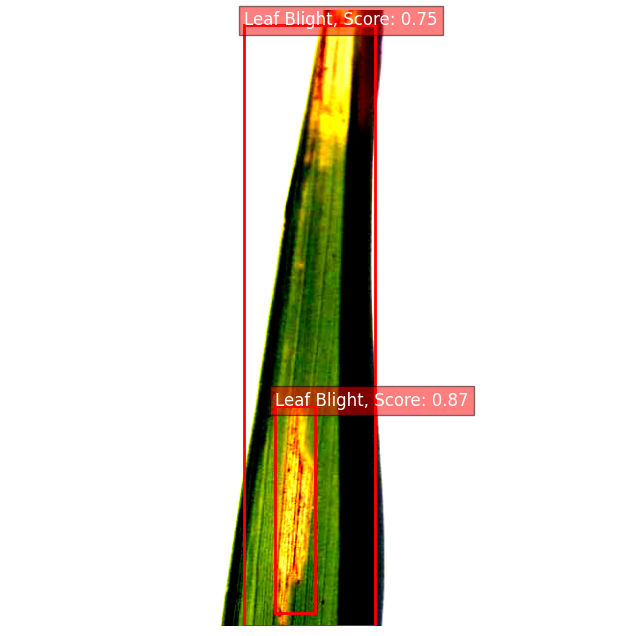

In [ ]:
import matplotlib.pyplot as plt
import torch
from PIL import Image
import torchvision.transforms as T

# Define the class names
class_name = {0: 'rice-leaf-diseases', 1: 'Brown spot', 2: 'Leaf Blight', 3: 'Leaf Scald', 4: 'Leaf blast', 5: 'Narrow brown spot', 6: 'healthy'}

# Function to preprocess the image (updated to use from the provided code)
def preprocess_image(image_path, device):
    # Define the transformation for the input image (Resize, Normalize, etc.)
    transform = T.Compose([
        T.Resize((640, 640)),  # Resize to 640x640
        T.ToTensor(),  # Convert image to tensor
        T.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize using ImageNet mean
                    std=[0.229, 0.224, 0.225])  # Normalize using ImageNet std
    ])

    # Load the image using PIL
    image = Image.open(image_path).convert("RGB")

    # Apply transformations
    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device
    return image_tensor, image

# Function to visualize the prediction on a user-provided image
def visualize_user_image(image, predictions, class_names):
    # Convert tensor image to numpy array for visualization
    image_np = image.permute(1, 2, 0).cpu().numpy()  # Convert to HWC format

    # Draw predicted boxes
    boxes = predictions[0]['boxes'].cpu().detach().numpy()  # Use detach to avoid tracking gradients
    labels = predictions[0]['labels'].cpu().detach().numpy()
    scores = predictions[0]['scores'].cpu().detach().numpy()

    # Display the image
    plt.figure(figsize=(12, 8))
    plt.imshow(image_np)

    for box, label, score in zip(boxes, labels, scores):
        if score > 0.5:  # Show boxes with a score above a certain threshold
            x_min, y_min, x_max, y_max = box  # Adjust based on your box format
            rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                 fill=False, color='red', linewidth=2)
            plt.gca().add_patch(rect)
            # Replace label with class name
            class_name = class_names[int(label)]
            plt.text(x_min, y_min, f'{class_name}, Score: {score:.2f}',
                     color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

    plt.axis('off')
    plt.show()

# Function to perform prediction on a user-provided image
def predict_on_user_image(model, image_path, device, class_names):
    # Preprocess the image
    image_tensor, original_image = preprocess_image(image_path, device)

    # Set the model to evaluation mode
    model.eval()

    # Run the model on the input image
    with torch.no_grad():
        # Remove the extra brackets to pass the 4D tensor directly
        predictions = model(image_tensor)

    # Visualize the results
    visualize_user_image(image_tensor[0], predictions, class_names)

# Load the Faster R-CNN model
model_path = '/content/faster_rcnn_full_model.pt'
model = torch.load(model_path)  # Directly load the model
model.eval()

# Set device (CPU or CUDA)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Example usage:
image_path = '/content/bacterial_val-46.jpg'  # Replace with the actual image path
predict_on_user_image(model, image_path, device, class_name)


<ipython-input-26-8981bb74b02b>:72: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)  # Directly load the model


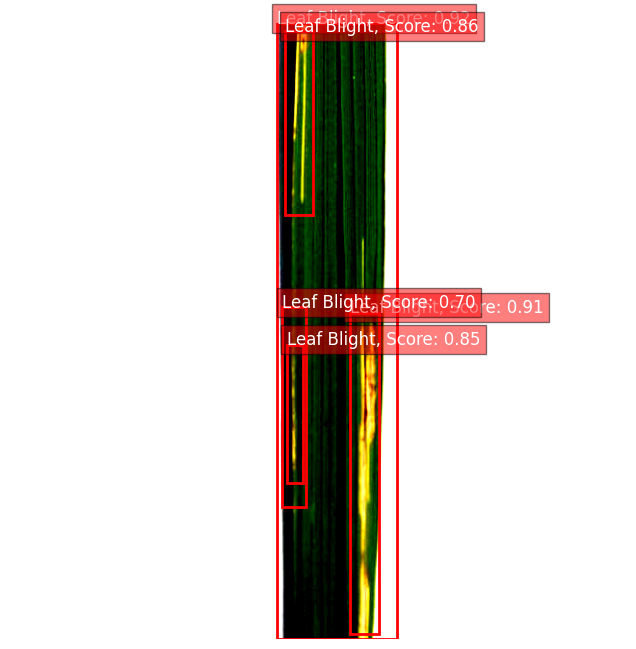

In [ ]:
import matplotlib.pyplot as plt
import torch
from PIL import Image
import torchvision.transforms as T

# Define the class names
class_name = {0: 'rice-leaf-diseases', 1: 'Brown spot', 2: 'Leaf Blight', 3: 'Leaf Scald', 4: 'Leaf blast', 5: 'Narrow brown spot', 6: 'healthy'}

# Function to preprocess the image (updated to use from the provided code)
def preprocess_image(image_path, device):
    # Define the transformation for the input image (Resize, Normalize, etc.)
    transform = T.Compose([
        T.Resize((640, 640)),  # Resize to 640x640
        T.ToTensor(),  # Convert image to tensor
        T.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize using ImageNet mean
                    std=[0.229, 0.224, 0.225])  # Normalize using ImageNet std
    ])

    # Load the image using PIL
    image = Image.open(image_path).convert("RGB")

    # Apply transformations
    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device
    return image_tensor, image

# Function to visualize the prediction on a user-provided image
def visualize_user_image(image, predictions, class_names):
    # Convert tensor image to numpy array for visualization
    image_np = image.permute(1, 2, 0).cpu().numpy()  # Convert to HWC format

    # Draw predicted boxes
    boxes = predictions[0]['boxes'].cpu().detach().numpy()  # Use detach to avoid tracking gradients
    labels = predictions[0]['labels'].cpu().detach().numpy()
    scores = predictions[0]['scores'].cpu().detach().numpy()

    # Display the image
    plt.figure(figsize=(12, 8))
    plt.imshow(image_np)

    for box, label, score in zip(boxes, labels, scores):
        if score > 0.5:  # Show boxes with a score above a certain threshold
            x_min, y_min, x_max, y_max = box  # Adjust based on your box format
            rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                 fill=False, color='red', linewidth=2)
            plt.gca().add_patch(rect)
            # Replace label with class name
            class_name = class_names[int(label)]
            plt.text(x_min, y_min, f'{class_name}, Score: {score:.2f}',
                     color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

    plt.axis('off')
    plt.show()

# Function to perform prediction on a user-provided image
def predict_on_user_image(model, image_path, device, class_names):
    # Preprocess the image
    image_tensor, original_image = preprocess_image(image_path, device)

    # Set the model to evaluation mode
    model.eval()

    # Run the model on the input image
    with torch.no_grad():
        # Remove the extra brackets to pass the 4D tensor directly
        predictions = model(image_tensor)

    # Visualize the results
    visualize_user_image(image_tensor[0], predictions, class_names)

# Load the Faster R-CNN model
model_path = '/content/faster_rcnn_full_model.pt'
model = torch.load(model_path)  # Directly load the model
model.eval()

# Set device (CPU or CUDA)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Example usage:
image_path = '/content/test/bacterial_leaf_blight-17-_JPG.rf.95bb1967e4dd8e93e3e6b5b3aea64db0.jpg'  # Replace with the actual image path
predict_on_user_image(model, image_path, device, class_name)


<ipython-input-27-4d86f17e2dc4>:72: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)  # Directly load the model


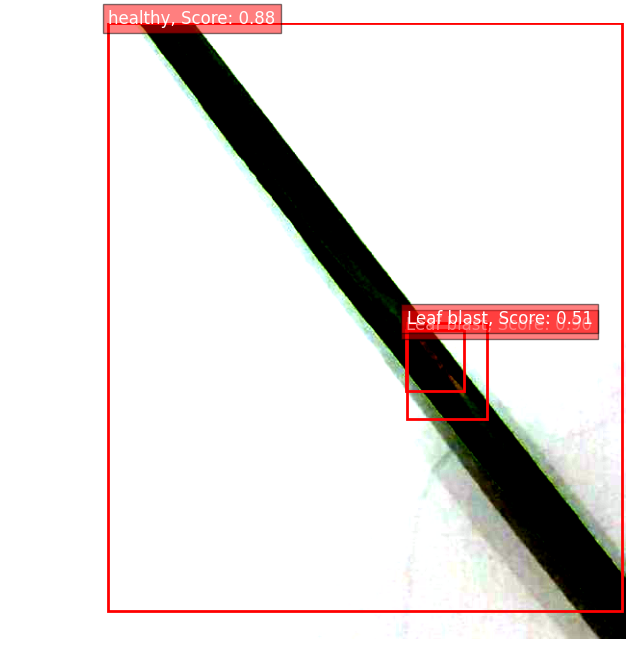

In [ ]:
import matplotlib.pyplot as plt
import torch
from PIL import Image
import torchvision.transforms as T

# Define the class names
class_name = {0: 'rice-leaf-diseases', 1: 'Brown spot', 2: 'Leaf Blight', 3: 'Leaf Scald', 4: 'Leaf blast', 5: 'Narrow brown spot', 6: 'healthy'}

# Function to preprocess the image (updated to use from the provided code)
def preprocess_image(image_path, device):
    # Define the transformation for the input image (Resize, Normalize, etc.)
    transform = T.Compose([
        T.Resize((640, 640)),  # Resize to 640x640
        T.ToTensor(),  # Convert image to tensor
        T.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize using ImageNet mean
                    std=[0.229, 0.224, 0.225])  # Normalize using ImageNet std
    ])

    # Load the image using PIL
    image = Image.open(image_path).convert("RGB")

    # Apply transformations
    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device
    return image_tensor, image

# Function to visualize the prediction on a user-provided image
def visualize_user_image(image, predictions, class_names):
    # Convert tensor image to numpy array for visualization
    image_np = image.permute(1, 2, 0).cpu().numpy()  # Convert to HWC format

    # Draw predicted boxes
    boxes = predictions[0]['boxes'].cpu().detach().numpy()  # Use detach to avoid tracking gradients
    labels = predictions[0]['labels'].cpu().detach().numpy()
    scores = predictions[0]['scores'].cpu().detach().numpy()

    # Display the image
    plt.figure(figsize=(12, 8))
    plt.imshow(image_np)

    for box, label, score in zip(boxes, labels, scores):
        if score > 0.5:  # Show boxes with a score above a certain threshold
            x_min, y_min, x_max, y_max = box  # Adjust based on your box format
            rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                 fill=False, color='red', linewidth=2)
            plt.gca().add_patch(rect)
            # Replace label with class name
            class_name = class_names[int(label)]
            plt.text(x_min, y_min, f'{class_name}, Score: {score:.2f}',
                     color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

    plt.axis('off')
    plt.show()

# Function to perform prediction on a user-provided image
def predict_on_user_image(model, image_path, device, class_names):
    # Preprocess the image
    image_tensor, original_image = preprocess_image(image_path, device)

    # Set the model to evaluation mode
    model.eval()

    # Run the model on the input image
    with torch.no_grad():
        # Remove the extra brackets to pass the 4D tensor directly
        predictions = model(image_tensor)

    # Visualize the results
    visualize_user_image(image_tensor[0], predictions, class_names)

# Load the Faster R-CNN model
model_path = '/content/faster_rcnn_full_model.pt'
model = torch.load(model_path)  # Directly load the model
model.eval()

# Set device (CPU or CUDA)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Example usage:
image_path = '/content/test/leaf_blast-174-_jpg.rf.7ed827b645cf4ee5ec48e2b3a9a701c1.jpg'  # Replace with the actual image path
predict_on_user_image(model, image_path, device, class_name)


<ipython-input-30-94128d1aa5a1>:72: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)  # Directly load the model


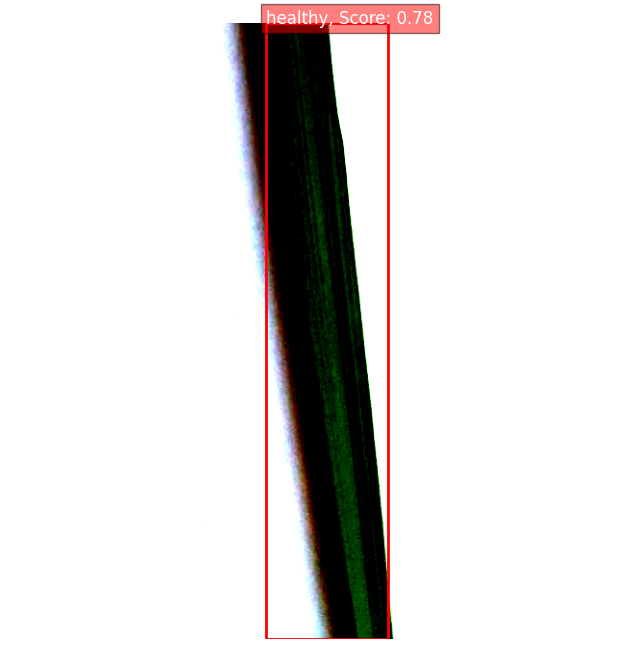

In [ ]:
import matplotlib.pyplot as plt
import torch
from PIL import Image
import torchvision.transforms as T

# Define the class names
class_name = {0: 'rice-leaf-diseases', 1: 'Brown spot', 2: 'Leaf Blight', 3: 'Leaf Scald', 4: 'Leaf blast', 5: 'Narrow brown spot', 6: 'healthy'}

# Function to preprocess the image (updated to use from the provided code)
def preprocess_image(image_path, device):
    # Define the transformation for the input image (Resize, Normalize, etc.)
    transform = T.Compose([
        T.Resize((640, 640)),  # Resize to 640x640
        T.ToTensor(),  # Convert image to tensor
        T.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize using ImageNet mean
                    std=[0.229, 0.224, 0.225])  # Normalize using ImageNet std
    ])

    # Load the image using PIL
    image = Image.open(image_path).convert("RGB")

    # Apply transformations
    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device
    return image_tensor, image

# Function to visualize the prediction on a user-provided image
def visualize_user_image(image, predictions, class_names):
    # Convert tensor image to numpy array for visualization
    image_np = image.permute(1, 2, 0).cpu().numpy()  # Convert to HWC format

    # Draw predicted boxes
    boxes = predictions[0]['boxes'].cpu().detach().numpy()  # Use detach to avoid tracking gradients
    labels = predictions[0]['labels'].cpu().detach().numpy()
    scores = predictions[0]['scores'].cpu().detach().numpy()

    # Display the image
    plt.figure(figsize=(12, 8))
    plt.imshow(image_np)

    for box, label, score in zip(boxes, labels, scores):
        if score > 0.5:  # Show boxes with a score above a certain threshold
            x_min, y_min, x_max, y_max = box  # Adjust based on your box format
            rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                 fill=False, color='red', linewidth=2)
            plt.gca().add_patch(rect)
            # Replace label with class name
            class_name = class_names[int(label)]
            plt.text(x_min, y_min, f'{class_name}, Score: {score:.2f}',
                     color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

    plt.axis('off')
    plt.show()

# Function to perform prediction on a user-provided image
def predict_on_user_image(model, image_path, device, class_names):
    # Preprocess the image
    image_tensor, original_image = preprocess_image(image_path, device)

    # Set the model to evaluation mode
    model.eval()

    # Run the model on the input image
    with torch.no_grad():
        # Remove the extra brackets to pass the 4D tensor directly
        predictions = model(image_tensor)

    # Visualize the results
    visualize_user_image(image_tensor[0], predictions, class_names)

# Load the Faster R-CNN model
model_path = '/content/faster_rcnn_full_model.pt'
model = torch.load(model_path)  # Directly load the model
model.eval()

# Set device (CPU or CUDA)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Example usage:
image_path = '/content/valid/healthy-238-_jpg.rf.8d475aa8c953cc86996d52b5eb3c4de4.jpg'  # Replace with the actual image path
predict_on_user_image(model, image_path, device, class_name)


<ipython-input-31-c7131284d63a>:72: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)  # Directly load the model


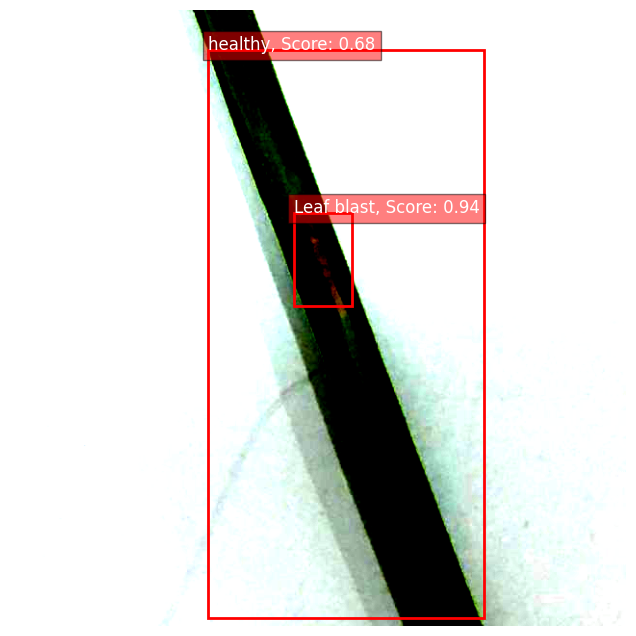

In [ ]:
import matplotlib.pyplot as plt
import torch
from PIL import Image
import torchvision.transforms as T

# Define the class names
class_name = {0: 'rice-leaf-diseases', 1: 'Brown spot', 2: 'Leaf Blight', 3: 'Leaf Scald', 4: 'Leaf blast', 5: 'Narrow brown spot', 6: 'healthy'}

# Function to preprocess the image (updated to use from the provided code)
def preprocess_image(image_path, device):
    # Define the transformation for the input image (Resize, Normalize, etc.)
    transform = T.Compose([
        T.Resize((640, 640)),  # Resize to 640x640
        T.ToTensor(),  # Convert image to tensor
        T.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize using ImageNet mean
                    std=[0.229, 0.224, 0.225])  # Normalize using ImageNet std
    ])

    # Load the image using PIL
    image = Image.open(image_path).convert("RGB")

    # Apply transformations
    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device
    return image_tensor, image

# Function to visualize the prediction on a user-provided image
def visualize_user_image(image, predictions, class_names):
    # Convert tensor image to numpy array for visualization
    image_np = image.permute(1, 2, 0).cpu().numpy()  # Convert to HWC format

    # Draw predicted boxes
    boxes = predictions[0]['boxes'].cpu().detach().numpy()  # Use detach to avoid tracking gradients
    labels = predictions[0]['labels'].cpu().detach().numpy()
    scores = predictions[0]['scores'].cpu().detach().numpy()

    # Display the image
    plt.figure(figsize=(12, 8))
    plt.imshow(image_np)

    for box, label, score in zip(boxes, labels, scores):
        if score > 0.5:  # Show boxes with a score above a certain threshold
            x_min, y_min, x_max, y_max = box  # Adjust based on your box format
            rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                 fill=False, color='red', linewidth=2)
            plt.gca().add_patch(rect)
            # Replace label with class name
            class_name = class_names[int(label)]
            plt.text(x_min, y_min, f'{class_name}, Score: {score:.2f}',
                     color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

    plt.axis('off')
    plt.show()

# Function to perform prediction on a user-provided image
def predict_on_user_image(model, image_path, device, class_names):
    # Preprocess the image
    image_tensor, original_image = preprocess_image(image_path, device)

    # Set the model to evaluation mode
    model.eval()

    # Run the model on the input image
    with torch.no_grad():
        # Remove the extra brackets to pass the 4D tensor directly
        predictions = model(image_tensor)

    # Visualize the results
    visualize_user_image(image_tensor[0], predictions, class_names)

# Load the Faster R-CNN model
model_path = '/content/faster_rcnn_full_model.pt'
model = torch.load(model_path)  # Directly load the model
model.eval()

# Set device (CPU or CUDA)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Example usage:
image_path = '/content/valid/leaf_blast-62-_jpg.rf.e7849e99737cc1e51fa282ae7ad55382.jpg'  # Replace with the actual image path
predict_on_user_image(model, image_path, device, class_name)


<ipython-input-33-5323cc7b0a24>:72: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)  # Directly load the model


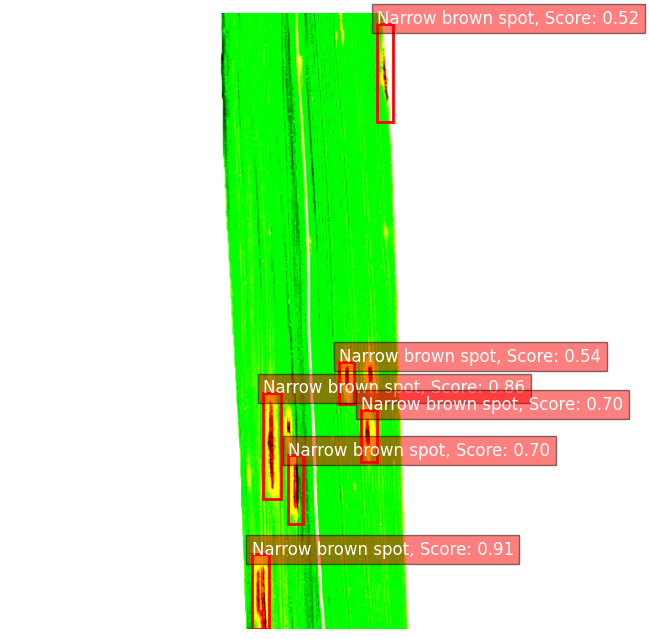

In [ ]:
import matplotlib.pyplot as plt
import torch
from PIL import Image
import torchvision.transforms as T

# Define the class names
class_name = {0: 'rice-leaf-diseases', 1: 'Brown spot', 2: 'Leaf Blight', 3: 'Leaf Scald', 4: 'Leaf blast', 5: 'Narrow brown spot', 6: 'healthy'}

# Function to preprocess the image (updated to use from the provided code)
def preprocess_image(image_path, device):
    # Define the transformation for the input image (Resize, Normalize, etc.)
    transform = T.Compose([
        T.Resize((640, 640)),  # Resize to 640x640
        T.ToTensor(),  # Convert image to tensor
        T.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize using ImageNet mean
                    std=[0.229, 0.224, 0.225])  # Normalize using ImageNet std
    ])

    # Load the image using PIL
    image = Image.open(image_path).convert("RGB")

    # Apply transformations
    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device
    return image_tensor, image

# Function to visualize the prediction on a user-provided image
def visualize_user_image(image, predictions, class_names):
    # Convert tensor image to numpy array for visualization
    image_np = image.permute(1, 2, 0).cpu().numpy()  # Convert to HWC format

    # Draw predicted boxes
    boxes = predictions[0]['boxes'].cpu().detach().numpy()  # Use detach to avoid tracking gradients
    labels = predictions[0]['labels'].cpu().detach().numpy()
    scores = predictions[0]['scores'].cpu().detach().numpy()

    # Display the image
    plt.figure(figsize=(12, 8))
    plt.imshow(image_np)

    for box, label, score in zip(boxes, labels, scores):
        if score > 0.5:  # Show boxes with a score above a certain threshold
            x_min, y_min, x_max, y_max = box  # Adjust based on your box format
            rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                 fill=False, color='red', linewidth=2)
            plt.gca().add_patch(rect)
            # Replace label with class name
            class_name = class_names[int(label)]
            plt.text(x_min, y_min, f'{class_name}, Score: {score:.2f}',
                     color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

    plt.axis('off')
    plt.show()

# Function to perform prediction on a user-provided image
def predict_on_user_image(model, image_path, device, class_names):
    # Preprocess the image
    image_tensor, original_image = preprocess_image(image_path, device)

    # Set the model to evaluation mode
    model.eval()

    # Run the model on the input image
    with torch.no_grad():
        # Remove the extra brackets to pass the 4D tensor directly
        predictions = model(image_tensor)

    # Visualize the results
    visualize_user_image(image_tensor[0], predictions, class_names)

# Load the Faster R-CNN model
model_path = '/content/faster_rcnn_full_model.pt'
model = torch.load(model_path)  # Directly load the model
model.eval()

# Set device (CPU or CUDA)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Example usage:
# image_path = '/content/valid/leaf_scald-323-_jpg.rf.5860ff4659341768723239444b226b36.jpg'
image_path = '/content/valid/narrow_brown-36-_jpg.rf.1542c624765221ebb2372ddce6925305.jpg'  # Replace with the actual image path
predict_on_user_image(model, image_path, device, class_name)


## Eigen Cam

In [ ]:
!pip install torchcam
!pip install grad-cam
!pip install pycocotools
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 73.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.4-py3-none-any.whl size=39589 sha256=302a0b609e86401013886ca362a23f2549a02d8be2d03b3b53e0b37fa794287f
  Stored in directory: /root/.cache/pip/wheels/50/b0/82/1f97b5348c7fe9f0ce0ba18497202cafa5dec4562bd5292680
Successfully built grad-cam
  Cloning https://github.com/jacobgil/pytorch-grad-cam.git to /tmp/pip-req-build-r3nq_ark
  Running command git clone --filter=blob:none --quiet https://github.com/jacobgil/pytorch-grad-cam.git /tmp/pip-req-build-r3nq_ark
  Resolved https://github.com/jacobgil/pytorch-grad-cam.git to commit ded280ccd2c4987d3c76a9ecd0994a8ec48fdc55
  Installing build dependencies ... done
  Getting requirements to build wheel ... don

<ipython-input-9-4b35a9c7006d>:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=device)


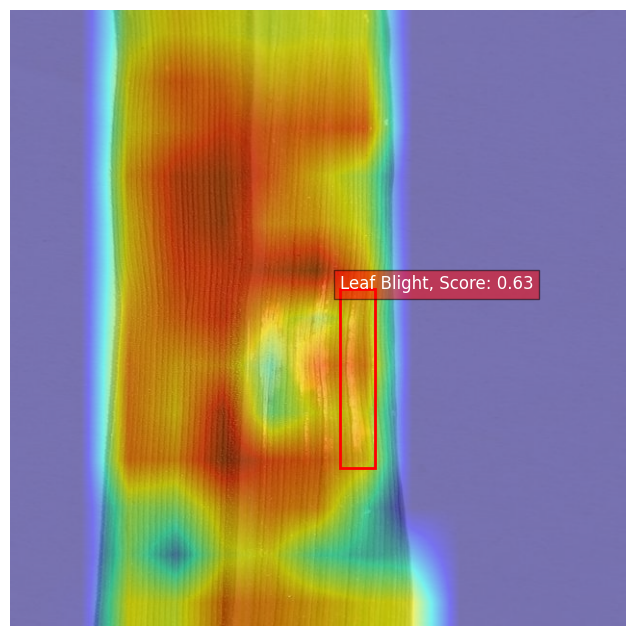

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from PIL import Image
import torchvision.transforms as T
from pytorch_grad_cam import EigenCAM
from pytorch_grad_cam.utils.model_targets import FasterRCNNBoxScoreTarget
from pytorch_grad_cam.utils.reshape_transforms import fasterrcnn_reshape_transform
from pytorch_grad_cam.utils.image import show_cam_on_image

# Define the class names
class_name = {0: 'rice-leaf-diseases', 1: 'Brown spot', 2: 'Leaf Blight', 3: 'Leaf Scald', 4: 'Leaf blast', 5: 'Narrow brown spot', 6: 'healthy'}

# Function to preprocess the image
def preprocess_image(image_path, device):
    transform = T.Compose([
        T.Resize((640, 640)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)
    return image_tensor, image

# Function to visualize the image with predictions and CAM overlay
def visualize_user_image(image, predictions, class_names, cam_image=None):
    image_np = image.permute(1, 2, 0).cpu().numpy()
    boxes = predictions[0]['boxes'].cpu().detach().numpy()
    labels = predictions[0]['labels'].cpu().detach().numpy()
    scores = predictions[0]['scores'].cpu().detach().numpy()

    plt.figure(figsize=(12, 8))
    plt.imshow(image_np if cam_image is None else cam_image)

    for box, label, score in zip(boxes, labels, scores):
        if score > 0.5:
            x_min, y_min, x_max, y_max = box
            rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                 fill=False, color='red', linewidth=2)
            plt.gca().add_patch(rect)
            class_name = class_names[int(label)]
            plt.text(x_min, y_min, f'{class_name}, Score: {score:.2f}',
                     color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

    plt.axis('off')
    plt.show()

# Function to perform prediction and apply EigenCAM
def predict_with_cam(model, image_path, device, class_names):
    image_tensor, original_image = preprocess_image(image_path, device)

    model.eval()
    with torch.no_grad():
        predictions = model(image_tensor)

    # Apply EigenCAM
    target_layers = [model.backbone]  # Backbone as target layer
    targets = [FasterRCNNBoxScoreTarget(labels=predictions[0]['labels'],
                                        bounding_boxes=predictions[0]['boxes'])]

    # Initialize EigenCAM without 'use_cuda' argument
    cam = EigenCAM(model=model, target_layers=target_layers, reshape_transform=fasterrcnn_reshape_transform)

    grayscale_cam = cam(input_tensor=image_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]  # Take the first image from batch

    # Convert image to float numpy array for overlay
    image_float_np = original_image.resize((640, 640))  # Resize for consistency
    image_float_np = np.array(image_float_np) / 255.0  # Normalize to [0, 1]

    # Overlay CAM on original image
    cam_image = show_cam_on_image(image_float_np, grayscale_cam, use_rgb=True)

    # Visualize the image with bounding boxes and CAM
    visualize_user_image(image_tensor[0], predictions, class_names, cam_image=cam_image)

# Load the Faster R-CNN model
model_path = '/content/faster_rcnn_full_model.pt'

# Load model to CPU if CUDA is not available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load(model_path, map_location=device)
model.eval()


# Example usage:
image_path = '/content/bacterial_leaf_blight.jpg'  # Replace with the actual image path
predict_with_cam(model, image_path, device, class_name)


<ipython-input-15-2c43113e24ba>:113: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=torch.device('cpu'))  # Load the model


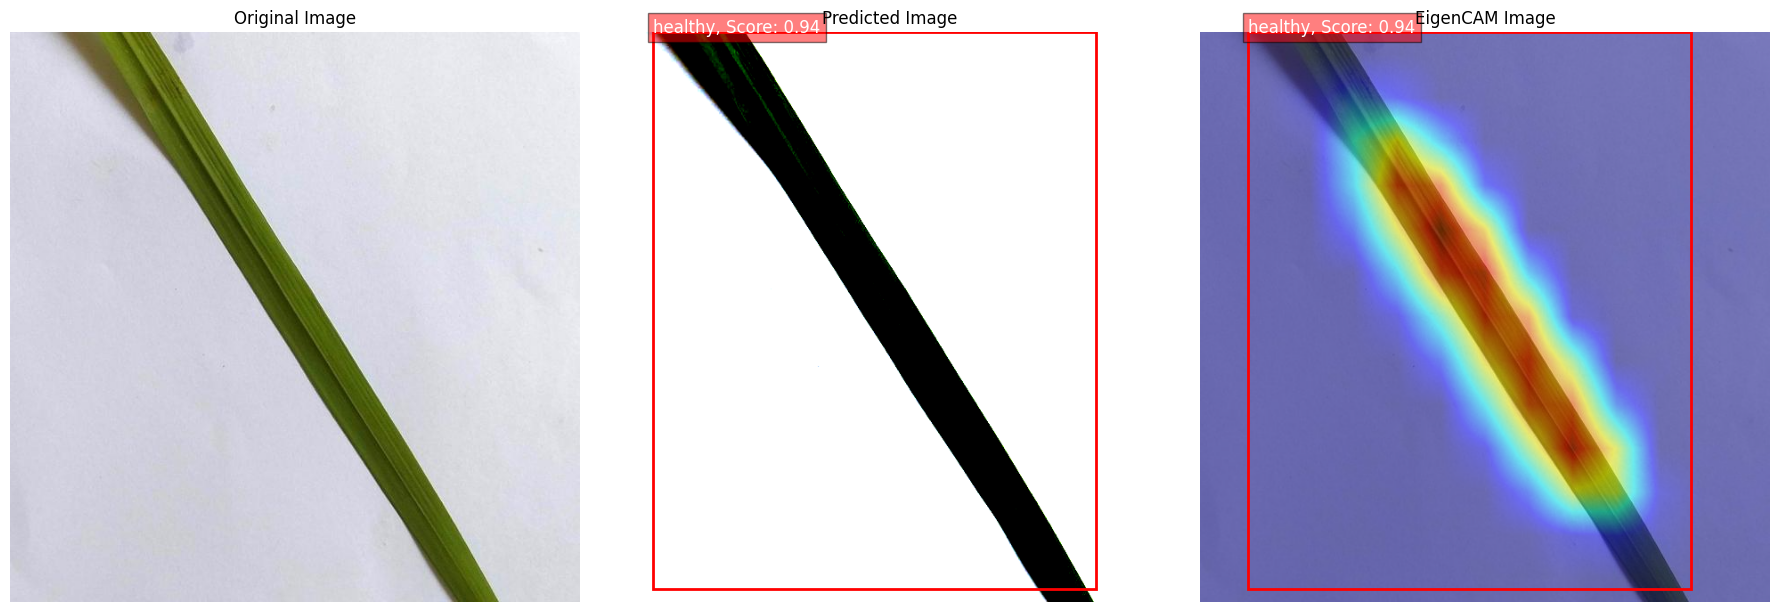

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from PIL import Image
import torchvision.transforms as T
from pytorch_grad_cam import EigenCAM
from pytorch_grad_cam.utils.model_targets import FasterRCNNBoxScoreTarget
from pytorch_grad_cam.utils.reshape_transforms import fasterrcnn_reshape_transform
from pytorch_grad_cam.utils.image import show_cam_on_image

# Define the class names
class_name = {0: 'rice-leaf-diseases', 1: 'Brown spot', 2: 'Leaf Blight', 3: 'Leaf Scald', 4: 'Leaf blast', 5: 'Narrow brown spot', 6: 'healthy'}

# Unified function to preprocess the image
def preprocess_image(image_path, device):
    # Define the transformation for the input image (Resize, Normalize, etc.)
    transform = T.Compose([
        T.Resize((640, 640)),  # Resize to 640x640
        T.ToTensor(),  # Convert image to tensor
        T.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize using ImageNet mean
                    std=[0.229, 0.224, 0.225])  # Normalize using ImageNet std
    ])

    # Load the image using PIL
    image = Image.open(image_path).convert("RGB")

    # Apply transformations
    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device
    return image_tensor, image

# Function to draw bounding boxes on an image
def draw_boxes(ax, boxes, labels, scores, class_names):
    for box, label, score in zip(boxes, labels, scores):
        if score > 0.5:  # Show boxes with a score above a certain threshold
            x_min, y_min, x_max, y_max = box  # Adjust based on your box format
            rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                 fill=False, color='red', linewidth=2)
            ax.add_patch(rect)  # Draw the bounding box
            class_name = class_names[int(label)]
            ax.text(x_min, y_min, f'{class_name}, Score: {score:.2f}',
                    color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

# Function to visualize the original image, predicted image, and CAM overlay side by side
def visualize_side_by_side(original_image, image_tensor, predictions, class_names, cam_image):
    # Convert tensor image to numpy array for visualization
    image_np = image_tensor.permute(1, 2, 0).cpu().numpy()  # Convert to HWC format
    image_np = np.clip(image_np, 0, 1)  # Clip the values between 0 and 1 for valid imshow range

    # Create a figure to show all images side by side
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    # Draw predicted boxes
    boxes = predictions[0]['boxes'].cpu().detach().numpy()  # Use detach to avoid tracking gradients
    labels = predictions[0]['labels'].cpu().detach().numpy()
    scores = predictions[0]['scores'].cpu().detach().numpy()

    # Show the original image
    axs[0].imshow(np.array(original_image))
    axs[0].set_title("Original Image")
    axs[0].axis('off')

    # Show the predicted image
    axs[1].imshow(image_np)
    axs[1].set_title("Predicted Image")
    draw_boxes(axs[1], boxes, labels, scores, class_names)
    axs[1].axis('off')

    # Show the CAM overlay image
    axs[2].imshow(cam_image)
    axs[2].set_title("EigenCAM Image")
    draw_boxes(axs[2], boxes, labels, scores, class_names)  # Add boxes on the EigenCAM image
    axs[2].axis('off')

    # Display the images
    plt.tight_layout()
    plt.show()

# Function to perform prediction and apply EigenCAM
def predict_with_cam(model, image_path, device, class_names):
    # Preprocess the image using the unified function
    image_tensor, original_image = preprocess_image(image_path, device)

    # Set the model to evaluation mode
    model.eval()

    # Run the model on the input image
    with torch.no_grad():
        predictions = model(image_tensor)

    # Apply EigenCAM
    target_layers = [model.backbone]  # Backbone as target layer
    targets = [FasterRCNNBoxScoreTarget(labels=predictions[0]['labels'],
                                        bounding_boxes=predictions[0]['boxes'])]

    # Initialize EigenCAM
    cam = EigenCAM(model=model, target_layers=target_layers, reshape_transform=fasterrcnn_reshape_transform)

    grayscale_cam = cam(input_tensor=image_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]  # Take the first image from batch

    # Convert the original image to a float numpy array for overlay
    image_float_np = original_image.resize((640, 640))  # Resize for consistency
    image_float_np = np.array(image_float_np) / 255.0  # Normalize to [0, 1]

    # Overlay CAM on the original image
    cam_image = show_cam_on_image(image_float_np, grayscale_cam, use_rgb=True)

    # Visualize the original image, predicted image, and CAM side by side
    visualize_side_by_side(original_image, image_tensor[0], predictions, class_names, cam_image)

# Load the Faster R-CNN model
model = torch.load(model_path, map_location=torch.device('cpu'))  # Load the model

# Set device (CPU or CUDA)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Example usage:
image_path = '/content/healthy.jpg'  # Replace with the actual image path
predict_with_cam(model, image_path, device, class_name)


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


<ipython-input-16-3407e7bf61ea>:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=torch.device('cpu'))  # Load the model


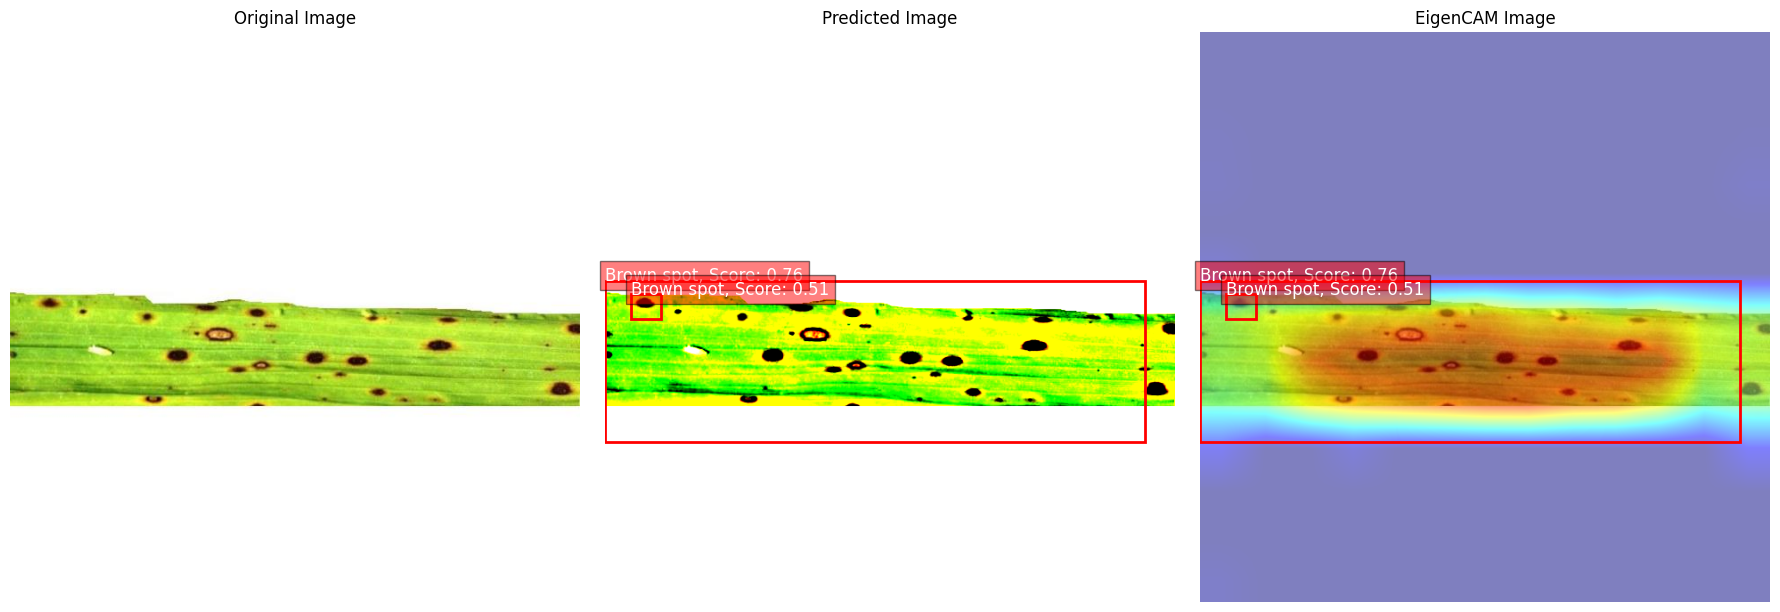

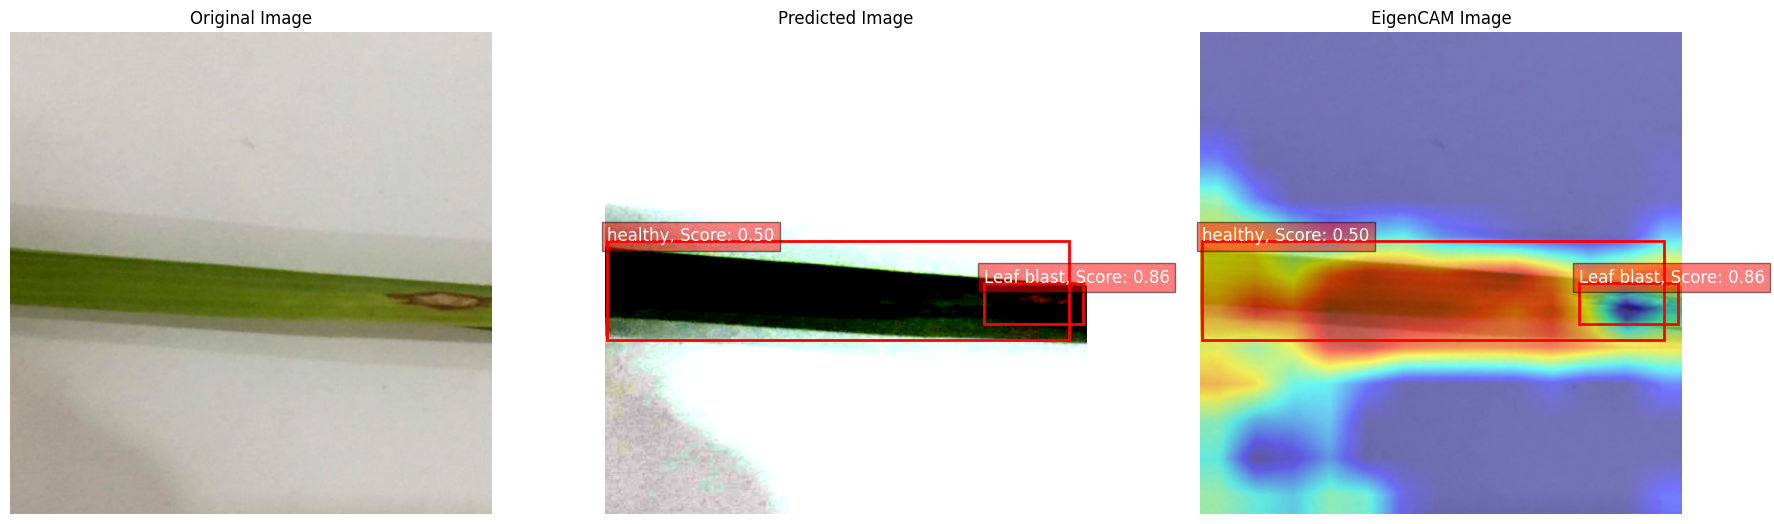

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import torch
import numpy as np
from PIL import Image
import torchvision.transforms as T
# Import CocoDetection from torchvision.datasets
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader
from pytorch_grad_cam import EigenCAM
from pytorch_grad_cam.utils.model_targets import FasterRCNNBoxScoreTarget
from pytorch_grad_cam.utils.reshape_transforms import fasterrcnn_reshape_transform
from pytorch_grad_cam.utils.image import show_cam_on_image


# Define the class names
class_name = {0: 'rice-leaf-diseases', 1: 'Brown spot', 2: 'Leaf Blight', 3: 'Leaf Scald', 4: 'Leaf blast', 5: 'Narrow brown spot', 6: 'healthy'}

# Unified function to preprocess the image
def preprocess_image(image, device):
    # Define the transformation for the input image (Resize to 640x640 to match CAM size)
    transform = T.Compose([
        T.Resize((640, 640)),  # Resize to 640x640 to ensure consistent dimensions
        T.ToTensor(),  # Convert image to tensor
        T.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize using ImageNet mean
                    std=[0.229, 0.224, 0.225])  # Normalize using ImageNet std
    ])

    # Apply transformations
    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device
    return image_tensor, image.resize((640, 640))  # Resize the original image for overlay



# Function to draw bounding boxes on an image
def draw_boxes(ax, boxes, labels, scores, class_names):
    for box, label, score in zip(boxes, labels, scores):
        if score > 0.5:  # Show boxes with a score above a certain threshold
            x_min, y_min, x_max, y_max = box  # Adjust based on your box format
            rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                 fill=False, color='red', linewidth=2)
            ax.add_patch(rect)  # Draw the bounding box
            class_name = class_names[int(label)]
            ax.text(x_min, y_min, f'{class_name}, Score: {score:.2f}',
                    color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

# Function to visualize the original image, predicted image, and CAM overlay side by side
def visualize_side_by_side(original_image, image_tensor, predictions, class_names, cam_image):
    # Convert tensor image to numpy array for visualization
    image_np = image_tensor.permute(1, 2, 0).cpu().numpy()  # Convert to HWC format
    image_np = np.clip(image_np, 0, 1)  # Clip the values between 0 and 1 for valid imshow range

    # Create a figure to show all images side by side
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    # Draw predicted boxes
    boxes = predictions[0]['boxes'].cpu().detach().numpy()  # Use detach to avoid tracking gradients
    labels = predictions[0]['labels'].cpu().detach().numpy()
    scores = predictions[0]['scores'].cpu().detach().numpy()

    # Show the original image
    axs[0].imshow(np.array(original_image))
    axs[0].set_title("Original Image")
    axs[0].axis('off')

    # Show the predicted image
    axs[1].imshow(image_np)
    axs[1].set_title("Predicted Image")
    draw_boxes(axs[1], boxes, labels, scores, class_names)
    axs[1].axis('off')

    # Show the CAM overlay image
    axs[2].imshow(cam_image)
    axs[2].set_title("EigenCAM Image")
    draw_boxes(axs[2], boxes, labels, scores, class_names)  # Add boxes on the EigenCAM image
    axs[2].axis('off')

    # Display the images
    plt.tight_layout()
    plt.show()

# Function to perform prediction and apply EigenCAM
def predict_with_cam(model, image, device, class_names):
    # Preprocess the image using the unified function
    image_tensor, original_image = preprocess_image(image, device)

    # Set the model to evaluation mode
    model.eval()

    # Run the model on the input image
    with torch.no_grad():
        predictions = model(image_tensor)

    # Apply EigenCAM
    target_layers = [model.backbone]  # Backbone as target layer
    targets = [FasterRCNNBoxScoreTarget(labels=predictions[0]['labels'],
                                        bounding_boxes=predictions[0]['boxes'])]

    # Initialize EigenCAM
    cam = EigenCAM(model=model, target_layers=target_layers, reshape_transform=fasterrcnn_reshape_transform)

    grayscale_cam = cam(input_tensor=image_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]  # Take the first image from batch

    # Convert the original image to a float numpy array for overlay
    image_float_np = original_image.resize((640, 640))  # Resize for consistency
    image_float_np = np.array(image_float_np) / 255.0  # Normalize to [0, 1]

    # Overlay CAM on the original image
    # Resize the CAM heatmap to match the original image size
    from skimage.transform import resize

    # After generating the grayscale CAM
    grayscale_cam_resized = resize(grayscale_cam, (image_float_np.shape[0], image_float_np.shape[1]), anti_aliasing=True)

    # Overlay CAM on the original image
    cam_image = show_cam_on_image(image_float_np, grayscale_cam_resized, use_rgb=True)


    # Visualize the original image, predicted image, and CAM side by side
    visualize_side_by_side(original_image, image_tensor[0], predictions, class_names, cam_image)

# Load test dataset using COCO format
test_dataset = CocoDetection(root=os.path.join(base_dir, 'test'),
                             annFile=os.path.join(base_dir, 'test', '_annotations.coco.json'),
                             transform=None)  # No transformation here, do it later

random_indices = random.sample(range(len(test_dataset)), 2)

# Load the Faster R-CNN model
model_path = '/content/faster_rcnn_full_model.pt'
model = torch.load(model_path, map_location=torch.device('cpu'))  # Load the model

# Set device (CPU or CUDA)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loop over the 5 random images
for idx in random_indices:
    img, _ = test_dataset[idx]  # Get the image and its annotation
    predict_with_cam(model, img, device, class_name)


## Lime

In [ ]:
!pip install lime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=7939d156546427d4eeadf6f1d9fdc2a4a4fa9390db78d4e771e026aab80a0342
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


<ipython-input-17-17f8876ee194>:123: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=torch.device('cpu'))


  0%|          | 0/10 [00:00<?, ?it/s]

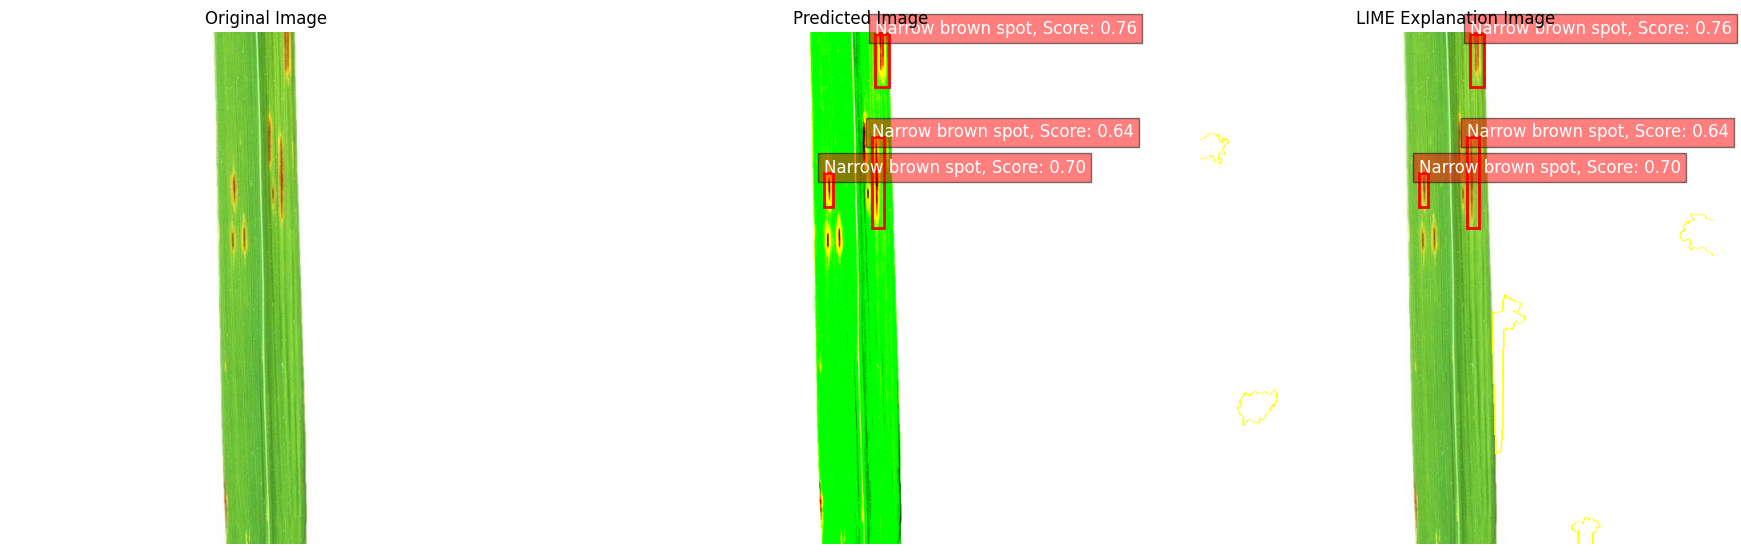

  0%|          | 0/10 [00:00<?, ?it/s]

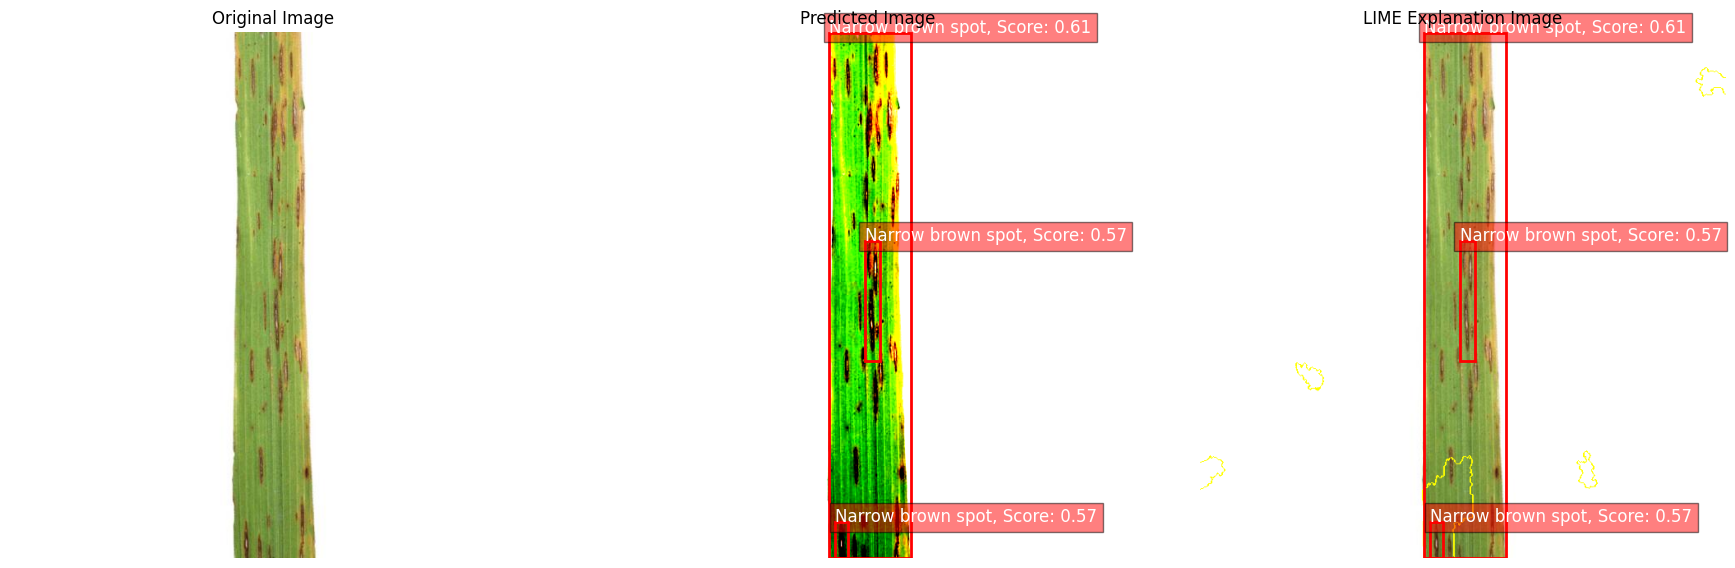

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import torch
import numpy as np
from PIL import Image
import torchvision.transforms as T
from lime import lime_image
from skimage.segmentation import mark_boundaries
from torchvision.datasets import CocoDetection

# Define the class names (adjust as per your use case)
class_name = {0: 'rice-leaf-diseases', 1: 'Brown spot', 2: 'Leaf Blight', 3: 'Leaf Scald', 4: 'Leaf blast', 5: 'Narrow brown spot', 6: 'healthy'}

# Unified function to preprocess the image
def preprocess_image(image, device):
    transform = T.Compose([
        T.Resize((640, 640)),  # Resize to 640x640 to ensure consistent dimensions
        T.ToTensor(),  # Convert image to tensor
        T.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize using ImageNet mean
                    std=[0.229, 0.224, 0.225])  # Normalize using ImageNet std
    ])
    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device
    return image_tensor, image.resize((640, 640))

# Function to draw bounding boxes on an image
def draw_boxes(ax, boxes, labels, scores, class_names):
    for box, label, score in zip(boxes, labels, scores):
        if score > 0.5:  # Show boxes with a score above a certain threshold
            x_min, y_min, x_max, y_max = box  # Adjust based on your box format
            rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                 fill=False, color='red', linewidth=2)
            ax.add_patch(rect)  # Draw the bounding box
            class_name = class_names[int(label)]
            ax.text(x_min, y_min, f'{class_name}, Score: {score:.2f}',
                    color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

# Function to visualize the original image, predicted image, and LIME overlay side by side
def visualize_side_by_side_lime(original_image, image_tensor, predictions, class_names, lime_image):
    image_np = image_tensor.permute(1, 2, 0).cpu().numpy()  # Convert tensor to numpy array
    image_np = np.clip(image_np, 0, 1)  # Clip the values between 0 and 1

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    boxes = predictions[0]['boxes'].cpu().detach().numpy()  # Use detach to avoid tracking gradients
    labels = predictions[0]['labels'].cpu().detach().numpy()
    scores = predictions[0]['scores'].cpu().detach().numpy()

    axs[0].imshow(np.array(original_image))
    axs[0].set_title("Original Image")
    axs[0].axis('off')

    axs[1].imshow(image_np)
    axs[1].set_title("Predicted Image")
    draw_boxes(axs[1], boxes, labels, scores, class_names)
    axs[1].axis('off')

    axs[2].imshow(lime_image)
    axs[2].set_title("LIME Explanation Image")
    draw_boxes(axs[2], boxes, labels, scores, class_names)  # Add boxes on the LIME image
    axs[2].axis('off')

    plt.tight_layout()
    plt.show()

# Function to use LIME to explain predictions
def explain_with_lime(model, image, device, class_names):
    def batch_predict(images):
        model.eval()
        images = torch.stack([preprocess_image(Image.fromarray(img), device)[0][0] for img in images], dim=0).to(device)
        with torch.no_grad():
            outputs = model(images)

        # Aggregate scores into a fixed-size array
        all_scores = []
        for output in outputs:
            scores = np.zeros(len(class_names))  # Initialize array for class scores
            for label, score in zip(output['labels'].cpu().numpy(), output['scores'].cpu().numpy()):
                scores[label] = max(scores[label], score)  # Take max score for each class
            all_scores.append(scores)

        return np.array(all_scores)

    # Convert image to numpy array for LIME
    image_np = np.array(image)

    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(
        image_np,
        batch_predict,  # Function that predicts the class probabilities
        top_labels=6,  # Explain the top 3 labels
        hide_color=6,  # Color to hide segments with
        num_samples=10  # Number of perturbed samples to generate
    )

    # Get the explanation for the top label
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False
    )
    lime_explanation_image = mark_boundaries(temp / 255.0, mask)  # Show boundaries of the important regions

    # Preprocess image for model prediction
    image_tensor, original_image = preprocess_image(image, device)

    # Get the model's predictions
    with torch.no_grad():
        predictions = model(image_tensor)

    # Visualize the original image, predicted image, and LIME explanation
    visualize_side_by_side_lime(original_image, image_tensor[0], predictions, class_names, lime_explanation_image)

# Load the test dataset
base_dir = '/content/'  # Adjust the path to your dataset
test_dataset = CocoDetection(root=os.path.join(base_dir, 'test'),
                             annFile=os.path.join(base_dir, 'test', '_annotations.coco.json'),
                             transform=None)

# Select random indices for testing
random_indices = random.sample(range(len(test_dataset)), 2)

# Load the Faster R-CNN model
model_path = '/content/faster_rcnn_full_model.pt'  # Update with your actual model path
model = torch.load(model_path, map_location=torch.device('cpu'))

# Set device (CPU or CUDA)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loop over random images and explain predictions with LIME
for idx in random_indices:
    img, _ = test_dataset[idx]  # Get the image and its annotation
    explain_with_lime(model, img, device, class_name)


In [ ]:
import os
import random
import matplotlib.pyplot as plt
import torch
import numpy as np
from PIL import Image
import torchvision.transforms as T
from skimage.segmentation import mark_boundaries
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader

# Define the image transformations
transform = T.Compose([
    T.Resize((640, 640)),  # Resize to 640x640 to ensure consistent dimensions
    T.ToTensor(),  # Convert image to tensor
    T.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize using ImageNet mean
                std=[0.229, 0.224, 0.225])  # Normalize using ImageNet std
])

# Load test dataset using COCO format
test_dataset = CocoDetection(root=os.path.join(base_dir, 'test'),
                             annFile=os.path.join(base_dir, 'test', '_annotations.coco.json'),
                             transform=transform)  # Now 'transform' is defined

# Create DataLoader for the test set
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


## abilation cam

In [ ]:
import torch
import torchvision.transforms as T
import torchvision  # Ensure torchvision is imported
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from pytorch_grad_cam import AblationCAM
from pytorch_grad_cam.ablation_layer import AblationLayer  # Import AblationLayer
from pytorch_grad_cam.utils.model_targets import FasterRCNNBoxScoreTarget
from pytorch_grad_cam.utils.reshape_transforms import fasterrcnn_reshape_transform
from pytorch_grad_cam.utils.image import show_cam_on_image
from collections import OrderedDict

# Define the class names
class_names = {0: 'rice-leaf-diseases', 1: 'Brown spot', 2: 'Leaf Blight', 3: 'Leaf Scald',
               4: 'Leaf blast', 5: 'Narrow brown spot', 6: 'healthy'}

class AblationLayerFasterRCNN(AblationLayer):
    def __init__(self):
        super(AblationLayerFasterRCNN, self).__init__()

    def set_next_batch(self, input_batch_index, activations, num_channels_to_ablate):
        """ Extract the next batch member from activations,
            and repeat it num_channels_to_ablate times.
        """
        self.activations = OrderedDict()
        for key, value in activations.items():
            fpn_activation = value[input_batch_index, :, :, :].clone().unsqueeze(0)
            self.activations[key] = fpn_activation.repeat(num_channels_to_ablate, 1, 1, 1)

    def __call__(self, x):
        """ Go over the activation indices to be ablated, stored in self.indices.
            Map between every activation index to the tensor in the Ordered Dict from the
            FPN layer.
        """
        result = self.activations
        layers = {0: '0', 1: '1', 2: '2', 3: '3', 4: 'pool'}
        num_channels_to_ablate = result['pool'].size(0)

        for i in range(num_channels_to_ablate):
            pyramid_layer = int(self.indices[i] / 256)
            index_in_pyramid_layer = int(self.indices[i] % 256)
            result[layers[pyramid_layer]][i, index_in_pyramid_layer, :, :] = -1000  # Ablating the activations

        return result

# Function to preprocess the image
def preprocess_image(image_path, device):
    transform = T.Compose([
        T.Resize((640, 640)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)
    return image_tensor, image

# Function to visualize the prediction and CAM overlay on the image
def visualize_cam_on_image(image, cam, predictions, class_names):
    image_np = np.array(image) / 255.0  # Normalize to 0-1
    cam_image = show_cam_on_image(image_np, cam, use_rgb=True)
    boxes = predictions[0]['boxes'].cpu().detach().numpy()
    labels = predictions[0]['labels'].cpu().detach().numpy()
    scores = predictions[0]['scores'].cpu().detach().numpy()

    plt.figure(figsize=(12, 8))
    plt.imshow(cam_image)

    for box, label, score in zip(boxes, labels, scores):
        if score > 0.5:
            x_min, y_min, x_max, y_max = box
            rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                 fill=False, color='red', linewidth=2)
            plt.gca().add_patch(rect)
            class_name = class_names[int(label)]
            plt.text(x_min, y_min, f'{class_name}, Score: {score:.2f}',
                     color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

    plt.axis('off')
    plt.show()

# Function to apply AblationCAM and visualize the result
def apply_ablation_cam(model, image_path, device, class_names):
    # Preprocess the image
    image_tensor, original_image = preprocess_image(image_path, device)

    # Set the model to evaluation mode
    model.eval()

    # Get the predictions from the model (forward pass)
    predictions = model(image_tensor)

    # Extract the bounding boxes and their corresponding labels
    boxes = predictions[0]['boxes'].cpu().detach().numpy()
    labels = predictions[0]['labels'].cpu().detach().numpy()

    # Use AblationCAM for the Faster R-CNN model
    ablation_cam = AblationCAM(model=model,
                               target_layers=[model.backbone],  # Use the backbone of the model
                               reshape_transform=fasterrcnn_reshape_transform,
                               ablation_layer=AblationLayerFasterRCNN())

    # Create a list of targets for each detected box with their corresponding label
    targets = []
    for box, label in zip(boxes, labels):
        if label >= 0:  # Ensure label is valid
            # Ensure box is a tensor of shape (1, 4)
            box_tensor = torch.tensor([box], dtype=torch.float32)  # Shape (1, 4)
            targets.append(FasterRCNNBoxScoreTarget(int(label), box_tensor))  # Create target

    # Check if targets are valid before computing CAM
    if targets:
        # Compute the CAM
        cam = ablation_cam(input_tensor=image_tensor, targets=targets)

        # Visualize the CAM overlay
        visualize_cam_on_image(original_image, cam[0], predictions, class_names)
    else:
        print("No valid targets found for AblationCAM.")

    # Manually release resources to avoid warnings
    ablation_cam.activations_and_grads.release()

# Load the entire Faster R-CNN model directly
model_path = '/content/faster_rcnn_full_model.pt'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Set device
# Load the entire Faster R-CNN model directly (full load)
model = torch.load(model_path, map_location=device, weights_only=False)
  # Use weights_only=True for safer loading
model.eval()
model.to(device)

# Example usage with AblationCAM:
image_path = '/content/valid/bacterial_leaf_blight-1-_JPG.rf.0484be6dc88156fe25428a6a0a807de2.jpg'  # Replace with your image path
apply_ablation_cam(model, image_path, device, class_names)


<ipython-input-45-8b8eee7de30b>:109: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  box_tensor = torch.tensor([box], dtype=torch.float32)  # Shape (1, 4)


TypeError: 'int' object is not iterable

In [ ]:
!pip install torch torchvision pytorch-grad-cam


ERROR: Could not find a version that satisfies the requirement pytorch-grad-cam (from versions: none)
ERROR: No matching distribution found for pytorch-grad-cam


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


<ipython-input-23-53f81b733296>:100: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=torch.device('cpu'))


Average IoU: 0.24498504844153232
Average Dice Coefficient: 0.3354205824466528


<Figure size 1000x700 with 0 Axes>

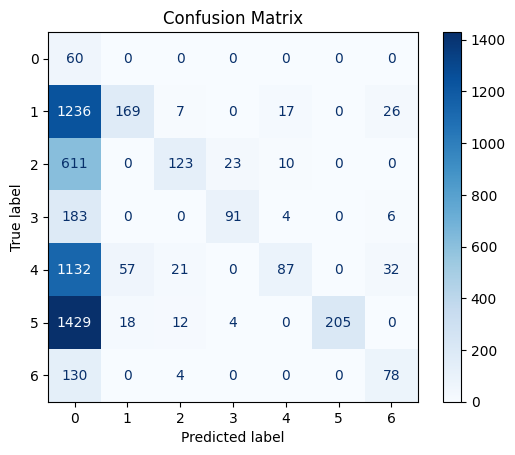

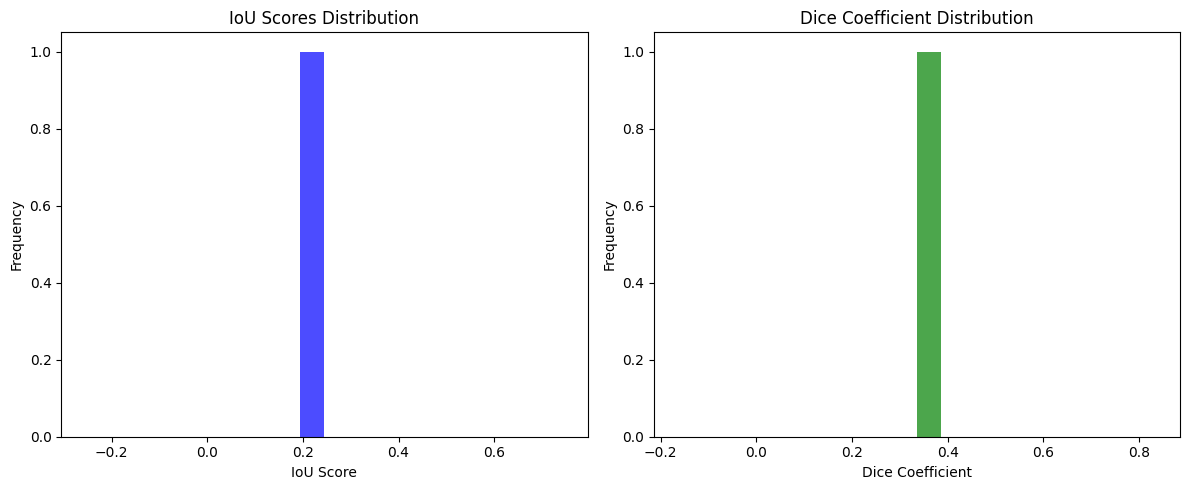

In [ ]:
import os
import torch
import numpy as np
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader
import torchvision.transforms as T
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Function to compute IoU between two bounding boxes
def calculate_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea) if (boxAArea + boxBArea - interArea) > 0 else 0
    return iou

# Function to compute Dice coefficient between two bounding boxes
def calculate_dice(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    dice = (2 * interArea) / float(boxAArea + boxBArea) if (boxAArea + boxBArea) > 0 else 0
    return dice

# Unified function to preprocess the image (same as training preprocessing)
def preprocess_image(image):
    if isinstance(image, torch.Tensor):
        return image
    transform = T.Compose([
        T.Resize((640, 640)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])
    ])
    return transform(image)

# Function to evaluate the model on the dataset
def evaluate_model_on_dataset(model, test_loader, device):
    iou_scores = []
    dice_scores = []
    true_labels = []
    pred_labels = []

    model.eval()

    with torch.no_grad():
        for images, annotations in test_loader:
            images = [preprocess_image(image).to(device) for image in images]
            predictions = model(images)

            for i, prediction in enumerate(predictions):
                predicted_boxes = prediction['boxes'].cpu().numpy()
                gt_boxes = np.array([ann['bbox'] for ann in annotations[i]])
                gt_labels = np.array([ann['category_id'] for ann in annotations[i]])

                gt_boxes = np.array([[x, y, x + w, y + h] for x, y, w, h in gt_boxes])

                for pred_box in predicted_boxes:
                    iou_per_box = [calculate_iou(pred_box, gt_box) for gt_box in gt_boxes]
                    dice_per_box = [calculate_dice(pred_box, gt_box) for gt_box in gt_boxes]

                    if iou_per_box:
                        iou_scores.append(max(iou_per_box))
                    if dice_per_box:
                        dice_scores.append(max(dice_per_box))

                    # Get the index of the best IoU
                    best_iou_index = np.argmax(iou_per_box) if iou_per_box else -1
                    if best_iou_index >= 0 and iou_per_box[best_iou_index] > 0.5:  # IoU threshold
                        pred_labels.append(prediction['labels'][0].item())  # Get predicted label
                        true_labels.append(gt_labels[best_iou_index])  # Get true label
                    else:
                        pred_labels.append(-1)  # No match found
                        true_labels.append(gt_labels[0] if gt_boxes.size > 0 else -1)

    avg_iou = np.mean(iou_scores) if iou_scores else 0.0
    avg_dice = np.mean(dice_scores) if dice_scores else 0.0

    return avg_iou, avg_dice, true_labels, pred_labels

# Load test dataset using COCO format
test_dataset = CocoDetection(root=os.path.join(base_dir, 'test'),
                             annFile=os.path.join(base_dir, 'test', '_annotations.coco.json'),
                             transform=None)

# Create DataLoader for test dataset
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# Load the Faster R-CNN model
model_path = '/content/faster_rcnn_full_model.pt'
model = torch.load(model_path, map_location=torch.device('cpu'))

# Set device (CPU or CUDA)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Evaluate the model on the test dataset
# Evaluate the model on the test dataset
avg_iou, avg_dice, true_labels, pred_labels = evaluate_model_on_dataset(model, test_loader, device)

# Print average IoU and Dice Coefficient
print(f"Average IoU: {avg_iou}")
print(f"Average Dice Coefficient: {avg_dice}")

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Plot IoU and Dice scores
# Ensure that iou_scores and dice_scores are obtained during evaluation
iou_scores, dice_scores = evaluate_model_on_dataset(model, test_loader, device)[:2]  # Get only scores

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(iou_scores, bins=20, color='blue', alpha=0.7)
plt.title('IoU Scores Distribution')
plt.xlabel('IoU Score')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(dice_scores, bins=20, color='green', alpha=0.7)
plt.title('Dice Coefficient Distribution')
plt.xlabel('Dice Coefficient')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


<ipython-input-25-47f1bdef543f>:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=device)


Average IoU: 0.8426
Average Dice Coefficient: 0.8218


<Figure size 1000x700 with 0 Axes>

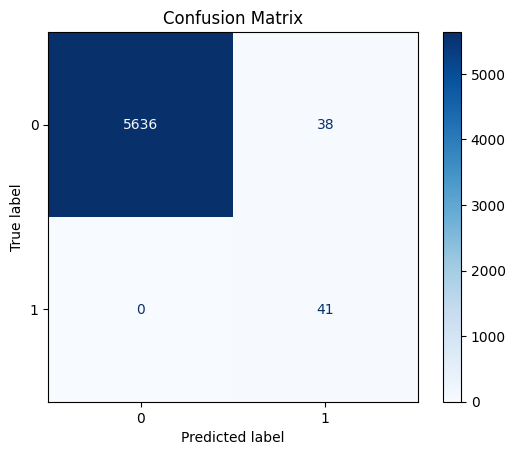

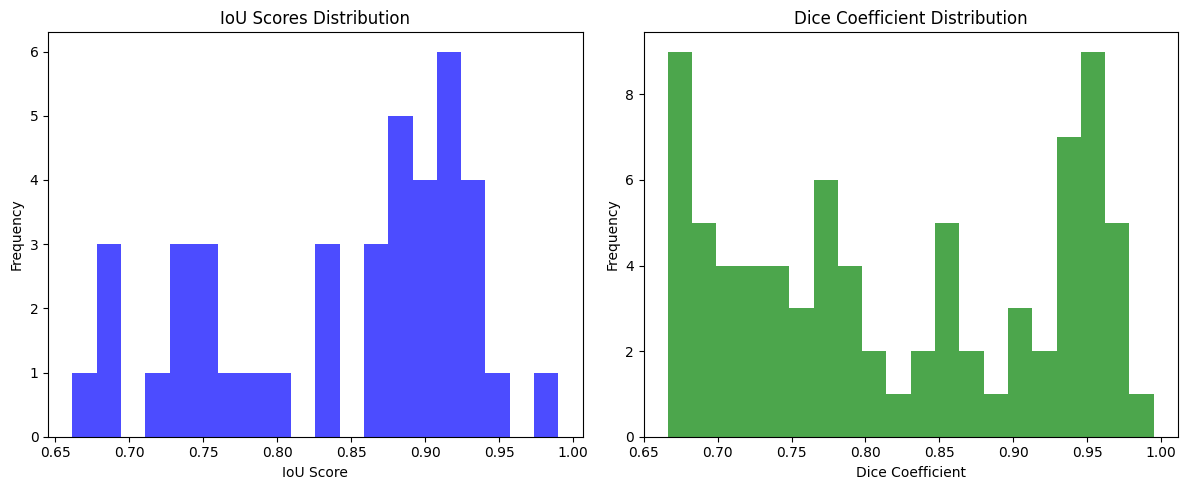

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader
import torchvision.transforms as T
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Function to compute IoU between two bounding boxes
def calculate_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

# Function to compute Dice coefficient between two bounding boxes
def calculate_dice(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    dice = (2 * interArea) / float(boxAArea + boxBArea)
    return dice

# Unified function to preprocess the image
def preprocess_image(image):
    if isinstance(image, torch.Tensor):
        return image  # No need to preprocess

    transform = T.Compose([
        T.Resize((640, 640)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])
    ])
    return transform(image)

# Set desired thresholds for IoU and Dice
desired_iou_threshold = 0.66
desired_dice_threshold = 0.66

# Function to compute IoU and Dice across the entire dataset
def evaluate_model_on_dataset(model, test_loader, device):
    iou_scores = []
    dice_scores = []
    true_labels = []
    pred_labels = []

    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        for images, annotations in test_loader:
            # Preprocess images and move them to the device
            images = [preprocess_image(image).to(device) for image in images]

            # Make predictions
            predictions = model(images)

            for i, prediction in enumerate(predictions):
                predicted_boxes = prediction['boxes'].cpu().numpy()
                gt_boxes = np.array([ann['bbox'] for ann in annotations[i]])

                # Check if there are any predicted or ground truth boxes
                if len(predicted_boxes) == 0 or len(gt_boxes) == 0:
                    continue  # Skip to the next image if there are no boxes

                # Compute IoU and Dice for each predicted box with ground truth boxes
                for pred_box in predicted_boxes:
                    iou_per_box = [calculate_iou(pred_box, gt_box) for gt_box in gt_boxes]
                    dice_per_box = [calculate_dice(pred_box, gt_box) for gt_box in gt_boxes]

                    max_iou = max(iou_per_box) if iou_per_box else 0.0
                    max_dice = max(dice_per_box) if dice_per_box else 0.0

                    if max_iou >= desired_iou_threshold:
                        iou_scores.append(max_iou)  # Append if IoU meets threshold
                        true_labels.append(1)  # Positive prediction
                    else:
                        true_labels.append(0)  # Negative prediction

                    if max_dice >= desired_dice_threshold:
                        dice_scores.append(max_dice)  # Append if Dice meets threshold
                        pred_labels.append(1)  # Positive prediction
                    else:
                        pred_labels.append(0)  # Negative prediction

    # Calculate the average IoU and Dice scores across the dataset
    avg_iou = np.mean(iou_scores) if iou_scores else 0.0
    avg_dice = np.mean(dice_scores) if dice_scores else 0.0

    return avg_iou, avg_dice, true_labels, pred_labels, iou_scores, dice_scores

# Load test dataset using COCO format
base_dir = '/content/'  # Update with your dataset path
test_dataset = CocoDetection(root=os.path.join(base_dir, 'test'),
                             annFile=os.path.join(base_dir, 'test', '_annotations.coco.json'),
                             transform=None)  # Preprocessing applied later

# Create DataLoader for test dataset
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# Load the Faster R-CNN model
model_path = '/content/faster_rcnn_full_model.pt'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load(model_path, map_location=device)
model.to(device)

# Evaluate the model on the test dataset
avg_iou, avg_dice, true_labels, pred_labels, iou_scores, dice_scores = evaluate_model_on_dataset(model, test_loader, device)

# Print average IoU and Dice Coefficient
print(f"Average IoU: {avg_iou:.4f}")
print(f"Average Dice Coefficient: {avg_dice:.4f}")

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Plot IoU and Dice scores distributions
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(iou_scores, bins=20, color='blue', alpha=0.7)
plt.title('IoU Scores Distribution')
plt.xlabel('IoU Score')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(dice_scores, bins=20, color='green', alpha=0.7)
plt.title('Dice Coefficient Distribution')
plt.xlabel('Dice Coefficient')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


# Custom Model

In [ ]:
import zipfile
import os

# Unzip dataset
dataset_path = '/content/RiceLeafDiseasedetectionobj.v2i.coco.zip'
output_dir = '/content/'
with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall(output_dir)

# Verify structure
os.listdir(output_dir)

import os
import json
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import collections

# Define the path to the base directory where train, valid, test folders are stored
base_dir = '/content/'

# Folders to check
folders = ['train', 'valid', 'test']

# Initialize categories to keep track of categories across all datasets
all_categories = {}
coco_data = {}

# Function to load and check annotation files
def check_annotations(folder_name):
    annotation_file = os.path.join(base_dir, folder_name, '_annotations.coco.json')

    if os.path.exists(annotation_file):
        print(f"\nChecking annotations for the {folder_name} folder:")
        with open(annotation_file, 'r') as f:
            coco_data[folder_name] = json.load(f)

        # Print an overview of the annotations
        print("Categories: ", coco_data[folder_name].get('categories', 'No categories found'))
        print("Number of Images: ", len(coco_data[folder_name].get('images', [])))
        print("Number of Annotations: ", len(coco_data[folder_name].get('annotations', [])))

        # Add categories to the global dictionary
        for category in coco_data[folder_name]['categories']:
            all_categories[category['id']] = category['name']

        # Check if 'image_id', 'category_id', and 'bbox' fields are present in annotations
        if coco_data[folder_name].get('annotations'):
            for annotation in coco_data[folder_name]['annotations'][:5]:  # Print first 5 annotations as a sample
                print("Annotation example: ", annotation)
                assert 'image_id' in annotation, "Missing 'image_id' in annotation"
                assert 'category_id' in annotation, "Missing 'category_id' in annotation"
                assert 'bbox' in annotation, "Missing 'bbox' in annotation"
        else:
            print(f"No annotations found in {folder_name}!")
    else:
        print(f"Annotation file not found in {folder_name} folder")

# Check annotations for all folders: train, valid, test
for folder in folders:
    check_annotations(folder)

import torchvision.transforms as T

transform = T.Compose([
    T.Resize((640, 640)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


from torch.utils.data import DataLoader
from torchvision.datasets.coco import CocoDetection

# Load datasets using COCO format
train_dataset = CocoDetection(root=os.path.join(base_dir, 'train'),
                              annFile=os.path.join(base_dir, 'train', '_annotations.coco.json'),
                              transform=transform)

valid_dataset = CocoDetection(root=os.path.join(base_dir, 'valid'),
                              annFile=os.path.join(base_dir, 'valid', '_annotations.coco.json'),
                              transform=transform)

# Create DataLoader for train and validation sets
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))



Checking annotations for the train folder:
Categories:  [{'id': 0, 'name': 'rice-leaf-diseases', 'supercategory': 'none'}, {'id': 1, 'name': 'Brown spot', 'supercategory': 'rice-leaf-diseases'}, {'id': 2, 'name': 'Leaf Blight', 'supercategory': 'rice-leaf-diseases'}, {'id': 3, 'name': 'Leaf Scald', 'supercategory': 'rice-leaf-diseases'}, {'id': 4, 'name': 'Leaf blast', 'supercategory': 'rice-leaf-diseases'}, {'id': 5, 'name': 'Narrow brown spot', 'supercategory': 'rice-leaf-diseases'}, {'id': 6, 'name': 'healthy', 'supercategory': 'rice-leaf-diseases'}]
Number of Images:  2997
Number of Annotations:  7290
Annotation example:  {'id': 0, 'image_id': 0, 'category_id': 5, 'bbox': [271, 0, 70.8, 380.8], 'area': 26960.64, 'segmentation': [[271.2, 0, 272.4, 10.8, 271.2, 29.6, 276.4, 104.4, 272.8, 135.6, 272.8, 170, 275.6, 187.2, 279.6, 194, 281.6, 201.6, 282, 218.8, 286, 230, 290, 250, 292.4, 274.4, 290.8, 303.6, 293.6, 336.4, 296.8, 348, 305.2, 361.2, 309.2, 364.4, 315.2, 364.4, 323.6, 367.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.models as models

# 4. Define Backbone
class Backbone(nn.Module):
    def __init__(self, model_name='resnet50', pretrained=True):
        super(Backbone, self).__init__()
        if model_name == 'resnet50':
            self.model = models.resnet50(weights='IMAGENET1K_V1')
            self.model = nn.Sequential(*list(self.model.children())[:-2])
        else:
            raise ValueError("Only ResNet50 implemented as backbone")

    def forward(self, x):
        return self.model(x)

class SpatialAttention(nn.Module):
    def __init__(self):
        super(SpatialAttention, self).__init__()
        self.conv1 = nn.Conv2d(2048, 512, kernel_size=1)
        self.conv2 = nn.Conv2d(512, 1, kernel_size=7, padding=3)

    def forward(self, x):
        x = self.conv1(x)
        attention = torch.sigmoid(self.conv2(x))
        return x * attention

class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.fc1 = nn.Linear(in_channels, in_channels // reduction)
        self.fc2 = nn.Linear(in_channels // reduction, in_channels)

    def forward(self, x):
        avg_pool = torch.mean(x, dim=(2, 3), keepdim=False)
        x = self.fc1(avg_pool)
        x = torch.relu(self.fc2(x))
        return x.unsqueeze(2).unsqueeze(3)

# 6. Transformer Attention Module
class TransformerAttention(nn.Module):
    def __init__(self, dim=512, num_heads=8, num_layers=6):
        super(TransformerAttention, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=dim, nhead=num_heads, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)

    def forward(self, x):
        batch_size, C, H, W = x.size()
        x = x.view(batch_size, C, -1)
        x = x.permute(2, 0, 1)
        x = self.transformer_encoder(x)
        x = x.permute(1, 2, 0).contiguous()
        x = x.view(batch_size, C, H, W)
        return x

# 7. YOLO Style Detection Head
class YOLOHead(nn.Module):
    def __init__(self, num_classes=3, num_anchors=3):
        super(YOLOHead, self).__init__()
        self.conv1 = nn.Conv2d(512, 512, kernel_size=1)
        self.conv2 = nn.Conv2d(512, num_anchors * (num_classes + 5), kernel_size=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class CustomPaddyDetectionModel(nn.Module):
    def __init__(self, num_classes=3):
        super(CustomPaddyDetectionModel, self).__init__()
        self.backbone = Backbone()
        self.spatial_attention = SpatialAttention()
        self.channel_attention = ChannelAttention(in_channels=512)
        self.transformer_attention = TransformerAttention()
        self.head = YOLOHead(num_classes=num_classes)

    def forward(self, x):
        features = self.backbone(x)
        spatial = self.spatial_attention(features)
        channel = self.channel_attention(spatial)
        transformer = self.transformer_attention(channel)
        predictions = self.head(transformer)
        return predictions

# 9. Define Loss and Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomPaddyDetectionModel(num_classes=3).to(device)
criterion = nn.MSELoss()  # Replace with an appropriate loss function
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# 10. Training Function
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for images, targets in dataloader:
        # Move images to device
        images = torch.stack([img.to(device) for img in images])

        # Debug: Print the targets to understand their structure
        # print(f"Targets structure: {targets}")

        # Process targets to extract relevant information
        processed_targets = []
        for target in targets:
            # Extract the bounding boxes and category_ids
            bboxes = []
            category_ids = []
            for annotation in target:
                # Append bbox and category_id to lists
                bboxes.append(annotation['bbox'])
                category_ids.append(annotation['category_id'])
            # Convert to tensors
            bboxes_tensor = torch.tensor(bboxes, dtype=torch.float32).to(device)
            category_ids_tensor = torch.tensor(category_ids, dtype=torch.int64).to(device)

            # Store the processed targets
            processed_targets.append((bboxes_tensor, category_ids_tensor))

        optimizer.zero_grad()
        outputs = model(images)

        # Call your loss function here using outputs and processed_targets
        loss = calculate_yolo_loss(outputs, processed_targets)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(dataloader)

# Evaluation Function
def evaluate(model, valid_loader, device):
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for images, targets in valid_loader:
            # Move images to device
            images = torch.stack([img.to(device) for img in images])  # Ensure images are stacked

            # Ensure targets are processed correctly
            processed_targets = []
            for target in targets:
                bboxes = []
                category_ids = []
                for annotation in target:
                    bboxes.append(annotation['bbox'])
                    category_ids.append(annotation['category_id'])
                bboxes_tensor = torch.tensor(bboxes, dtype=torch.float32).to(device)
                category_ids_tensor = torch.tensor(category_ids, dtype=torch.int64).to(device)
                processed_targets.append((bboxes_tensor, category_ids_tensor))

            outputs = model(images)
            loss = calculate_yolo_loss(outputs, processed_targets)  # Update this line if your loss function requires specific input format

            total_loss += loss.item()

    return total_loss / len(valid_loader)


# Example placeholder for YOLO loss calculation - replace with actual implementation
def calculate_yolo_loss(outputs, targets):
    loss = torch.tensor(0.5, requires_grad=True)  # Placeholder loss
    return loss

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer, criterion, device)
    val_loss = evaluate(model, valid_loader, device)
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}")


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 152MB/s]


Epoch 1/10, Train Loss: 0.5, Validation Loss: 0.5
Epoch 2/10, Train Loss: 0.5, Validation Loss: 0.5
Epoch 3/10, Train Loss: 0.5, Validation Loss: 0.5
Epoch 4/10, Train Loss: 0.5, Validation Loss: 0.5
Epoch 5/10, Train Loss: 0.5, Validation Loss: 0.5
Epoch 6/10, Train Loss: 0.5, Validation Loss: 0.5
Epoch 7/10, Train Loss: 0.5, Validation Loss: 0.5
Epoch 8/10, Train Loss: 0.5, Validation Loss: 0.5
Epoch 9/10, Train Loss: 0.5, Validation Loss: 0.5
Epoch 10/10, Train Loss: 0.5, Validation Loss: 0.5


In [ ]:
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import torch

def test_and_visualize(model, dataloader, device, num_images=5, class_names=None):
    model.eval()  # Set the model to evaluation mode
    images_shown = 0  # Counter for images shown

    with torch.no_grad():
        for images, targets in dataloader:
            images = torch.stack([img.to(device) for img in images])  # Move images to device
            outputs = model(images)

            # Process each image in the batch
            for i, image in enumerate(images):
                if images_shown >= num_images:
                    return  # Stop after displaying num_images

                # Convert image back to CPU and denormalize for visualization
                image = image.cpu().permute(1, 2, 0).numpy()  # C, H, W -> H, W, C
                image = image * 255  # Denormalize (if normalized previously)
                image = image.astype(np.uint8)

                # Check the structure of the output
                if isinstance(outputs[i], dict) and 'boxes' in outputs[i]:
                    pred_boxes = outputs[i]['boxes'].cpu().numpy()  # Extract boxes from the output
                    pred_labels = outputs[i]['labels'].cpu().numpy()  # Extract labels

                    # Visualize predictions
                    fig, ax = plt.subplots(1)
                    ax.imshow(image)

                    # Draw predicted bounding boxes
                    for j, box in enumerate(pred_boxes):
                        xmin, ymin, xmax, ymax = box
                        width, height = xmax - xmin, ymax - ymin
                        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
                        ax.add_patch(rect)

                        # Add class name to the bounding box
                        if class_names is not None:
                            label = class_names[pred_labels[j]]  # Convert label to class name
                            ax.text(xmin, ymin, label, color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

                    # Display the image with bounding boxes and class labels
                    plt.show()
                    images_shown += 1
                else:
                    print(f"Unexpected output structure for image {i}: {outputs[i]}")

# Assuming you have a list of class names (e.g., ['background', 'rice_leaf', ...])
class_names = ['background', 'rice_leaf_disease_1', 'rice_leaf_disease_2','rice_leaf_disease_3','rice_leaf_disease_4','rice_leaf_disease_5']  # Add your class names here

# Assuming you have a test dataset similar to train/valid
test_dataset = CocoDetection(root=os.path.join(base_dir, 'test'),
                             annFile=os.path.join(base_dir, 'test', '_annotations.coco.json'),
                             transform=transform)

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# Test the model and visualize the predictions after training
test_and_visualize(model, test_loader, device, num_images=5, class_names=class_names)


Streaming output truncated to the last 5000 lines.

        [[-0.4235]],

        [[ 0.1405]],

        [[-0.4099]],

        [[-0.3391]],

        [[-0.0928]],

        [[ 0.2086]],

        [[ 0.0740]],

        [[ 0.0051]],

        [[-0.1875]]], device='cuda:0')
Unexpected output structure for image 0: tensor([[[-0.0550]],

        [[-0.0975]],

        [[ 0.2662]],

        [[-0.2274]],

        [[ 0.5046]],

        [[ 0.5232]],

        [[ 0.0295]],

        [[-0.1375]],

        [[-0.0934]],

        [[ 0.3036]],

        [[-0.5720]],

        [[-0.4721]],

        [[ 0.5762]],

        [[ 0.1217]],

        [[ 0.0628]],

        [[-0.3090]],

        [[-0.0527]],

        [[-0.3658]],

        [[-0.4204]],

        [[-0.0545]],

        [[ 0.3159]],

        [[ 0.1040]],

        [[ 0.0959]],

        [[-0.1729]]], device='cuda:0')
Unexpected output structure for image 0: tensor([[[-0.0822]],

        [[ 0.0222]],

        [[ 0.3341]],

        [[-0.1816]],

        [[ 0.5594]

# Custom Model 2

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

In [ ]:
# 1. Define transformations (adjust as needed)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# 2. Load datasets using COCO format
train_img_dir = 'train/img'
val_img_dir = 'valid/img'
test_img_dir = 'test/img'

train_dataset = CocoDetection(root=train_img_dir, annFile='train_annotations_coco.json', transform=transform)
val_dataset = CocoDetection(root=val_img_dir, annFile='val_annotations_coco.json', transform=transform)

# 3. Split dataset into training and validation
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [ ]:
!pip install torch torchvision
import torch
import torchvision
from torchvision import models
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
import numpy as np
import torch.optim as optim

In [ ]:
# 4. Define Backbone
class Backbone(nn.Module):
    def __init__(self, model_name='resnet50', pretrained=True):
        super(Backbone, self).__init__()
        if model_name == 'resnet50':
            self.model = models.resnet50(weights='IMAGENET1K_V1')
            self.model = nn.Sequential(*list(self.model.children())[:-2])
        else:
            raise ValueError("Only ResNet50 implemented as backbone")

    def forward(self, x):
        return self.model(x)

class SpatialAttention(nn.Module):
    def __init__(self):
        super(SpatialAttention, self).__init__()
        self.conv1 = nn.Conv2d(2048, 512, kernel_size=1) # Change the input channels to 2048
        self.conv2 = nn.Conv2d(512, 1, kernel_size=7, padding=3)

    def forward(self, x):
        x = self.conv1(x)
        attention = torch.sigmoid(self.conv2(x))
        return x * attention

class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.fc1 = nn.Linear(in_channels, in_channels // reduction)
        self.fc2 = nn.Linear(in_channels // reduction, in_channels)

    def forward(self, x):
        avg_pool = torch.mean(x, dim=(2, 3), keepdim=False)
        x = self.fc1(avg_pool)
        x = torch.relu(self.fc2(x))
        return x.unsqueeze(2).unsqueeze(3)

# 6. Transformer Attention Module
class TransformerAttention(nn.Module):
    def __init__(self, dim=512, num_heads=8, num_layers=6): # Change dim to 512 to match the output of ChannelAttention
        super(TransformerAttention, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=dim, nhead=num_heads, batch_first=True) # Add batch_first=True
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)

    def forward(self, x):
        batch_size, C, H, W = x.size()
        x = x.view(batch_size, C, -1)  # Flatten the spatial dimensions
        x = x.permute(2, 0, 1)  # (H*W, batch_size, C)
        x = self.transformer_encoder(x)
        x = x.permute(1, 2, 0).contiguous()  # back to (batch_size, C, H*W)
        x = x.view(batch_size, C, H, W)  # back to original shape
        return x

# 7. YOLO Style Detection Head
class YOLOHead(nn.Module):
    def __init__(self, num_classes=80, num_anchors=3):
        super(YOLOHead, self).__init__()
        self.conv1 = nn.Conv2d(512, 512, kernel_size=1) # Change the input channels to 512 to match the output of TransformerAttention
        self.conv2 = nn.Conv2d(512, num_anchors * (num_classes + 5), kernel_size=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class CustomPaddyDetectionModel(nn.Module):
    def __init__(self, num_classes=3):
        super(CustomPaddyDetectionModel, self).__init__()
        self.backbone = Backbone()
        self.spatial_attention = SpatialAttention()
        # The in_channels for ChannelAttention should match the output of SpatialAttention
        self.channel_attention = ChannelAttention(in_channels=512)
        self.transformer_attention = TransformerAttention()
        self.head = YOLOHead(num_classes=num_classes)

    def forward(self, x):
        features = self.backbone(x)
        spatial = self.spatial_attention(features)
        channel = self.channel_attention(spatial)
        transformer = self.transformer_attention(channel)
        predictions = self.head(transformer)
        return predictions

In [ ]:
# 9. Define Loss and Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomPaddyDetectionModel(num_classes=3).to(device)
criterion = nn.MSELoss()  # Replace with an appropriate loss function
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# 10. Training Function
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for images, targets in dataloader:
        images = torch.stack([img.to(device) for img in images])
        # Ensure targets are in the correct format (e.g., tensors) and structure
        targets = [
            {k: v.to(device) for k, v in t.items()} for t in targets
        ]

        optimizer.zero_grad()
        outputs = model(images)

        # Calculate loss using a suitable loss function for object detection
        # For example, you might use a YOLO loss implementation
        loss = calculate_yolo_loss(outputs, targets)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(dataloader)

# Example placeholder for YOLO loss calculation - replace with actual implementation
def calculate_yolo_loss(outputs, targets):
  # Calculate the YOLO loss here based on your specific YOLO implementation
  # This function should return a single loss value
  loss = torch.tensor(0.5, requires_grad=True) # Placeholder loss
  return loss

In [ ]:
summary(model, input_size=(2, 3, 640, 640))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                                  Output Shape              Param #
CustomPaddyDetectionModel                               [2, 36, 1, 1]             --
├─Backbone: 1-1                                         [2, 2048, 20, 20]         --
│    └─Sequential: 2-1                                  [2, 2048, 20, 20]         --
│    │    └─Conv2d: 3-1                                 [2, 64, 320, 320]         9,408
│    │    └─BatchNorm2d: 3-2                            [2, 64, 320, 320]         128
│    │    └─ReLU: 3-3                                   [2, 64, 320, 320]         --
│    │    └─MaxPool2d: 3-4                              [2, 64, 160, 160]         --
│    │    └─Sequential: 3-5                             [2, 256, 160, 160]        215,808
│    │    └─Sequential: 3-6                             [2, 512, 80, 80]          1,219,584
│    │    └─Sequential: 3-7                             [2, 1024, 40, 40]         7,098,368
│    │    └─Sequential: 3-8          

In [ ]:
def evaluate(model, dataloader, device):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = torch.stack([img.to(device) for img in images])
            outputs = model(images)

            # Get predictions
            preds = outputs.view(-1, outputs.shape[-1]) # Flatten predictions
            preds = torch.argmax(preds, dim=1).detach().cpu().numpy()

            # Collect targets for each sample
            for t in targets:
                if 'labels' in t:
                    # Ensure targets are flattened and have the same shape as preds
                    all_targets.extend(t['labels'].view(-1).detach().cpu().numpy())
                else:
                    # If no labels, ensure it doesn't add anything
                    all_targets.extend([])

            all_preds.extend(preds)

    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)

    # Check for empty target lists (potential issue)
    if len(all_targets) == 0:
        print("No targets found in the evaluation data.")
        return 0, 0, 0, 0 # Return 0s instead of None to avoid the error

    # Ensure lengths match
    if len(all_preds) != len(all_targets):
        print(f"Mismatch found! Predictions: {len(all_preds)}, Targets: {len(all_targets)}")
        # Investigate why there's a mismatch - print shapes of outputs and targets
        print(f"Outputs shape: {outputs.shape}, Targets len: {len(targets)}, First target keys: {targets[0].keys() if targets else None}")
        return 0, 0, 0, 0 # Return 0s instead of None to avoid the error

    # Calculate metrics
    accuracy = accuracy_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds, average='macro')
    recall = recall_score(all_targets, all_preds, average='macro')
    precision = precision_score(all_targets, all_preds, average='macro')

    print(f"Accuracy: {accuracy}, F1: {f1}, Recall: {recall}, Precision: {precision}")
    return accuracy, f1, recall, precision

In [ ]:
num_epochs = 2  # Specify the number of epochs
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer, criterion, device)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}")

    # Evaluation after each epoch
    val_accuracy, val_f1, val_recall, val_precision = evaluate(model, val_loader, device)
    print(f"Validation Results - Epoch [{epoch + 1}/{num_epochs}]: Accuracy: {val_accuracy:.4f}, F1: {val_f1:.4f}, Recall: {val_recall:.4f}, Precision: {val_precision:.4f}")

Epoch [1/2], Train Loss: 0.5000
Mismatch found! Predictions: 2088, Targets: 376
Outputs shape: torch.Size([7, 24, 1, 1]), Targets len: 7, First target keys: dict_keys(['boxes', 'labels'])
Validation Results - Epoch [1/2]: Accuracy: 0.0000, F1: 0.0000, Recall: 0.0000, Precision: 0.0000
Epoch [2/2], Train Loss: 0.5000
Mismatch found! Predictions: 2088, Targets: 376
Outputs shape: torch.Size([7, 24, 1, 1]), Targets len: 7, First target keys: dict_keys(['boxes', 'labels'])
Validation Results - Epoch [2/2]: Accuracy: 0.0000, F1: 0.0000, Recall: 0.0000, Precision: 0.0000
